In [63]:
from credit_helper import *
import os
import warnings
warnings.filterwarnings('ignore')

In [64]:
mydir = os.getcwd()

---
---

### HW1Q1 - Explore symbology for US treasuries and corporate bonds
1. Load the `govt_symbology` Excel file into a dataframe. For each government bond issue, calculate its initial term/time-to-maturity in years (based on issue date and maturity date), as well as the current time-to-maturity. Assume a year has 365.25 days, or use QuantLib yearFraction() function.
2. Plot the time series of coupons for for US treasury notes/bonds issued in the last 10 years (indexed by issue date). What can you say about the overall level of the coupons in the last 2 years?
3. Load the `govt_on_the_run` Excel file into a dataframe. Select the current on-the-run 2Y, 3Y, 5Y, 7Y, 10Y, 20Y and 30Y issues (off-the-run issues have the B & C suffix). Create a separate symbology dataframe for on-the-run treasuries only, to be used later on for the on-the-run government yield curve bootstrapping.
4. Load the `corp_symbology` Excel file into a dataframe. 
5. Create a new (filtered) dataframe for 
   * bullet/non-callable (mty_typ="AT MATURITY"), 
   * senior unsecured (rank = "Sr Unsecured"),
   * fixed coupon (cpn_type="FIXED") <br>
 
where, 
   * `term` refers to the initial term/time-to-maturity in years
   * `TTM` refers to the current time-to-maturity in years
>


In [65]:
govt_symbology = pd.read_excel(os.path.join(mydir , 'data' , 'govt_symbology.xlsx'))
govt_symbology = govt_symbology[govt_symbology['cpn_type'] == 'FIXED']
govt_symbology = govt_symbology.reset_index(drop=True)
govt_symbology = get_symbology(govt_symbology)

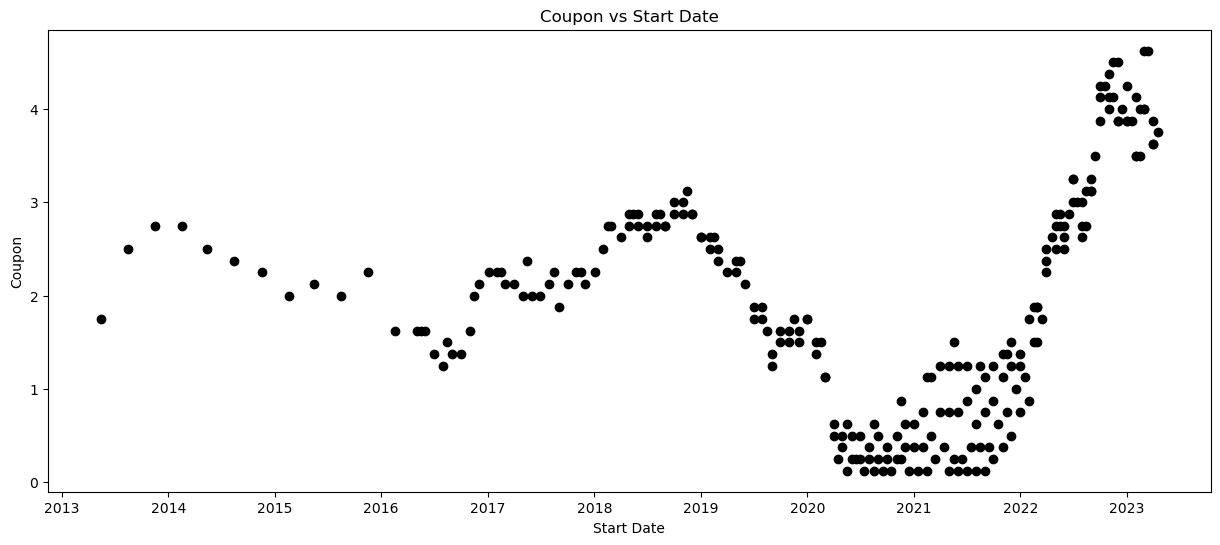

In [66]:
#filter out the start dates older than 10 years from 04/14/2023
govt_symbology_plot = govt_symbology[govt_symbology['term'] <= 10]
#remove all the zero coupon bonds
govt_symbology_plot = govt_symbology_plot[govt_symbology_plot['coupon'] != 0]
#create scatter plot using matplotlib
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(govt_symbology_plot['start_date'], govt_symbology_plot['coupon'], color='black')
ax.set_xlabel('Start Date')
ax.set_ylabel('Coupon')
ax.set_title('Coupon vs Start Date')
plt.show()

In [67]:
gov_otr = pd.read_excel(os.path.join(mydir , 'data' , 'govt_on_the_run.xlsx'))
gov_otr = gov_otr[~gov_otr['ticker'].str.contains('B')]
gov_otr = gov_otr[~gov_otr['ticker'].str.contains('C')]
gov_otr.reset_index(drop=True, inplace=True)
gov_otr_symbology = govt_symbology[govt_symbology['isin'].isin(gov_otr['isin'])]
gov_otr_symbology.sort_values(by=['TTM'], inplace=True)
gov_otr_symbology = get_symbology(gov_otr_symbology)

### HW1Q2 - Explore EOD market prices and yields
1. Load the `market_prices_eod` Excel file into a dataframe. It provides market data for US treasuries and corporate bonds of 2023-04-14. Join the treasuries symbology dataframe with the market data
2. Plot a graph/scatter plot of treasury mid yields by TTM.
3. Create a separate joint dataframe for on-the-run treasuries only.
4. Plot a graph/scatter plot of on-the-run treasury mid yields by TTM.
5. Join the filtered corporate bonds symbology dataframe with the market data.
6. Plot a graph/scatter plot of mid yield curves by TTM (one line per ticker/issuer).
7. Add a separate line for on-the-run US treasury yield curve (risk free curve). What can you say about the credit issuer yields, compared to US treasury yields?

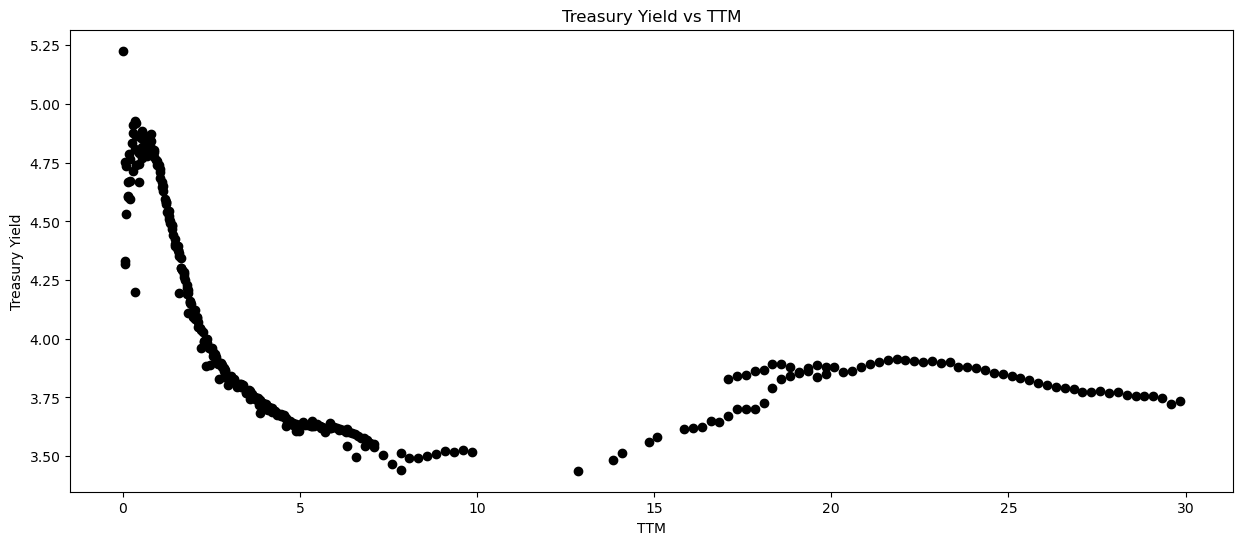

In [68]:
md = pd.read_excel(os.path.join(mydir , 'data' , 'market_prices_eod.xlsx'))
govt_symbology_md = pd.merge(govt_symbology, md, on='figi', how='inner', suffixes=('', '_y'))
govt_symbology_md.rename(columns={'mid_clean': 'mid'}, inplace=True)
govt_symbology_md['mid_yield'] = (govt_symbology_md['ask_yield'] + govt_symbology_md['bid_yield'])/2
govt_symbology_md.sort_values(by=['mid_yield'], inplace=True)
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(govt_symbology_md['TTM'], govt_symbology_md['mid_yield'], color='black')
ax.set_xlabel('TTM')
ax.set_ylabel('Treasury Yield')
ax.set_title('Treasury Yield vs TTM')
plt.show()

In [69]:
corp_symbology = pd.read_excel(os.path.join(mydir , 'data' , 'corp_symbology.xlsx'))
corp_symbology = corp_symbology[(corp_symbology['mty_typ'] == 'AT MATURITY') & (corp_symbology['rank'] == 'Sr Unsecured') & (corp_symbology['cpn_type'] == 'FIXED')]
corp_symbology = get_symbology(corp_symbology)

corp_symbology_md = pd.merge(corp_symbology, md, on='figi', how='inner', suffixes=('', '_y'))
corp_symbology_md.rename(columns={'mid_clean': 'mid'}, inplace=True)
corp_symbology_md.drop(columns=['ticker_y'], inplace=True)

corp_symbology_md['mid_yield'] = (corp_symbology_md['ask_yield'] + corp_symbology_md['bid_yield'])/2
corp_symbology_md.sort_values(by=['TTM'], inplace=True)
corp_symbology_md.reset_index(drop=True, inplace=True)

Loading corp_symbology again without so many restrictions

In [71]:
corp_symbology = pd.read_excel(os.path.join(mydir , 'data' , 'corp_symbology.xlsx'))
corp_symbology = corp_symbology[(corp_symbology['cpn_type'] == 'FIXED')]
corp_symbology = get_symbology(corp_symbology)

In [74]:
md

,date,class,ticker,isin,figi,bid,ask,mid_clean,mid_dirty,bid_yield,ask_yield
0,2023-04-14,Corp,DIS,US254687CZ75,BBG00QNKJ092,98.6780,98.8480,98.7630,99.1020,4.679,4.551
1,2023-04-14,Corp,DIS,US254687DD54,BBG00QNKPCL5,98.4540,98.8210,98.6370,98.6680,4.361,4.203
2,2023-04-14,Corp,DIS,US254687DK97,BBG00QNKGJP6,97.0900,97.3690,97.2300,98.6640,4.260,4.174
3,2023-04-14,Corp,DIS,US254687DV52,BBG00QNKP8R8,115.1630,115.9840,115.5740,116.1740,4.624,4.529
4,2023-04-14,Corp,DIS,US254687DZ66,BBG00QNKR4J4,112.9390,113.5860,113.2620,115.3800,4.742,4.674
...,...,...,...,...,...,...,...,...,...,...,...
592,2023-04-14,Govt,T,US91282CGR60,BBG01FQJ5MY4,102.1250,102.1563,102.1406,102.5547,3.845,3.834
593,2023-04-14,Govt,T,US91282CGS44,BBG01G14BV75,100.3750,100.4375,100.4063,100.5742,3.563,3.553
594,2023-04-14,Govt,T,US91282CGT27,BBG01G14BW91,100.0703,100.0859,100.0781,100.2461,3.609,3.606
595,2023-04-14,Govt,T,US91282CGU99,BBG01G14BXX2,99.5703,99.5820,99.5762,99.7559,4.105,4.099


In [73]:
gov_otr_symbology

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,cpn_freq,days_settle,start_date,cpn_first,acc_first,maturity,country,currency,term,TTM
330,T,Govt,BBG01G14BXX2,US91282CGU99,TSRYS5557560,T 3 7/8 03/31/25,US TREASURY N/B,US GOVERNMENT,3.875,FIXED,...,2.0,1,2023-03-31,2023-09-30,2023-03-31,2025-03-31,US,USD,2.00,1.963039
331,T,Govt,BBG01G5ZMM43,US91282CGV72,TSRYS5565937,T 3 3/4 04/15/26,US TREASURY N/B,US GOVERNMENT,3.750,FIXED,...,2.0,1,2023-04-17,2023-10-15,2023-04-15,2026-04-15,US,USD,3.00,3.003422
329,T,Govt,BBG01G14BW91,US91282CGT27,TSRYS5557562,T 3 5/8 03/31/28,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,2.0,1,2023-03-31,2023-09-30,2023-03-31,2028-03-31,US,USD,5.00,4.963723
328,T,Govt,BBG01G14BV75,US91282CGS44,TSRYS5557563,T 3 5/8 03/31/30,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,2.0,1,2023-03-31,2023-09-30,2023-03-31,2030-03-31,US,USD,7.00,6.962355
323,T,Govt,BBG01DVKBC66,US91282CGM73,TSRYS5533941,T 3 1/2 02/15/33,US TREASURY N/B,US GOVERNMENT,3.500,FIXED,...,2.0,1,2023-02-15,2023-08-15,2023-02-15,2033-02-15,US,USD,10.00,9.842574
89,T,Govt,BBG01F6N6GN1,US912810TQ13,TSRYS5536898,T 3 7/8 02/15/43,US TREASURY N/B,US GOVERNMENT,3.875,FIXED,...,2.0,1,2023-02-28,2023-08-15,2023-02-15,2043-02-15,US,USD,19.96,19.841205
88,T,Govt,BBG01DVKBH56,US912810TN81,TSRYS5533944,T 3 5/8 02/15/53,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,2.0,1,2023-02-15,2023-08-15,2023-02-15,2053-02-15,US,USD,30.00,29.842574


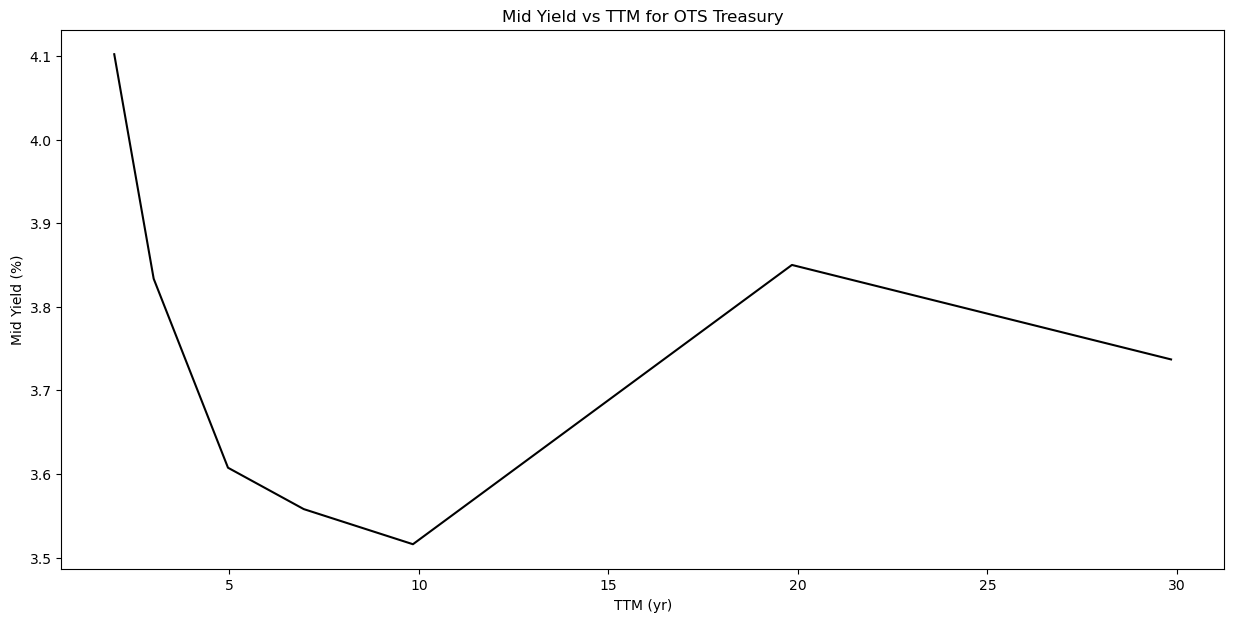

In [75]:
gov_otr_symbology.reset_index(drop=True, inplace=True)
gov_otr_symbology_md = pd.merge(gov_otr_symbology, md, on='figi', how='inner', suffixes=('', '_y'))
gov_otr_symbology_md.rename(columns={'mid_clean': 'mid'}, inplace=True)
gov_otr_symbology_md['mid_yield'] = (gov_otr_symbology_md['ask_yield'] + gov_otr_symbology_md['bid_yield'])/2
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(gov_otr_symbology_md['TTM'], gov_otr_symbology_md['mid_yield'], color='black')
ax.set_xlabel('TTM (yr)')
ax.set_ylabel('Mid Yield (%)')
ax.set_title('Mid Yield vs TTM for OTS Treasury')
plt.show()

### HW1Q3 - Underying treasury benchmarks and credit spreads
1. Use the column 'und_bench_yield' to identify the underlying benchmark bond for each issue. Add two new columns to the joint corporate bond dataframe.
*  `und_bench_yield` = underlying benchmark bond mid yield and
*  `credit_spread` = issue yield - underlying benchmark bond mid yield.
2. Plot a graph/scatter plot of credit spread curves by TTM (one line per issuer).
3. Add two new columns to the joint corporate bond dataframe:
*  `interp_tsy_yield` = interpolated treasury yield (using on-the-run treasuries only), matching the issue maturity
*  `g_spread` = issue yield - interp_tsy_yield.
4. Plot a graph/scatter plot of g-spread curves by TTM (one line per issuer).

In [10]:
corp_symbology_md['und_bench_yield'] = corp_symbology_md['und_bench_isin'].map(govt_symbology_md.set_index('isin')['mid_yield'])
corp_symbology_md['credit_spread'] = corp_symbology_md['mid_yield'] - corp_symbology_md['und_bench_yield']
corp_symbology_md = corp_symbology_md.dropna(subset=['credit_spread'])
corp_symbology_md.sort_values(by=['TTM'], inplace=True)
corp_symbology_md.reset_index(drop=True, inplace=True)
corp_symbology_md.head()

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,isin_y,bid,ask,mid,mid_dirty,bid_yield,ask_yield,mid_yield,und_bench_yield,credit_spread
0,DIS,Corp,BBG00N36B7D0,USU25497AG02,DIS4809907,US91282CGU99,DIS 7 3/4 01/20/24,WALT DISNEY COMPANY/THE,EURO-DOLLAR,7.750,...,USU25497AG02,101.739,102.165,101.952,103.847,5.354,4.782,5.0680,4.102,0.9660
1,IBM,Corp,BBG005ZC4J89,US459200HU86,IBM4096360,US91282CGU99,IBM 3 5/8 02/12/24,IBM CORP,GLOBAL,3.625,...,US459200HU86,98.747,98.999,98.873,99.538,5.205,4.884,5.0445,4.102,0.9425
2,VZ,Corp,BBG00ZLKTDJ4,US92343VGF58,VZ5148416,US91282CGU99,VZ 0 3/4 03/22/24,VERIZON COMMUNICATIONS,GLOBAL,0.750,...,US92343VGF58,95.975,96.327,96.151,96.205,5.251,4.846,5.0485,4.102,0.9465
3,MS,Corp,BBG006DDT5Z2,US61746BDQ68,MS4119530,US91282CGU99,MS 3 7/8 04/29/24,MORGAN STANLEY,GLOBAL,3.875,...,US61746BDQ68,98.470,98.741,98.606,100.425,5.420,5.144,5.2820,4.102,1.1800
4,IBM,Corp,BBG00P3BLGV3,US459200JY80,IBM4832193,US91282CGU99,IBM 3 05/15/24,IBM CORP,GLOBAL,3.000,...,US459200JY80,98.057,98.258,98.158,99.433,4.875,4.678,4.7765,4.102,0.6745


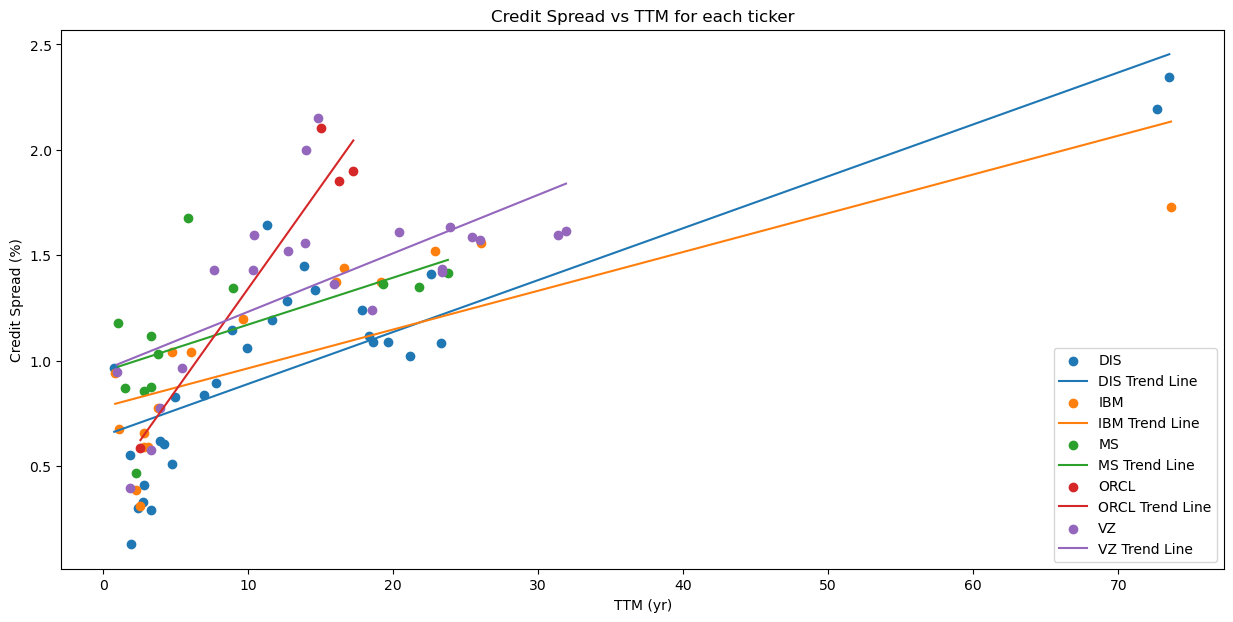

In [11]:
fig, ax = plt.subplots(figsize=(15, 7))
for ticker, group in corp_symbology_md.groupby('ticker'):
    ax.scatter(group['TTM'], group['credit_spread'], label=ticker)
    #add best fit line
    z = np.polyfit(group['TTM'], group['credit_spread'], 1)
    p = np.poly1d(z)
    plt.plot(group['TTM'], p(group['TTM']), label = f'{ticker} Trend Line')
ax.set_xlabel('TTM (yr)')
ax.set_ylabel('Credit Spread (%)')
ax.set_title('Credit Spread vs TTM for each ticker')
plt.legend()
plt.show()

In [12]:
corp_symbology_md = get_interp_tsy_yield(corp_symbology_md, gov_otr_symbology_md)
corp_symbology_md['g_spread'] = corp_symbology_md['mid_yield'] - corp_symbology_md['interp_tsy_yield']

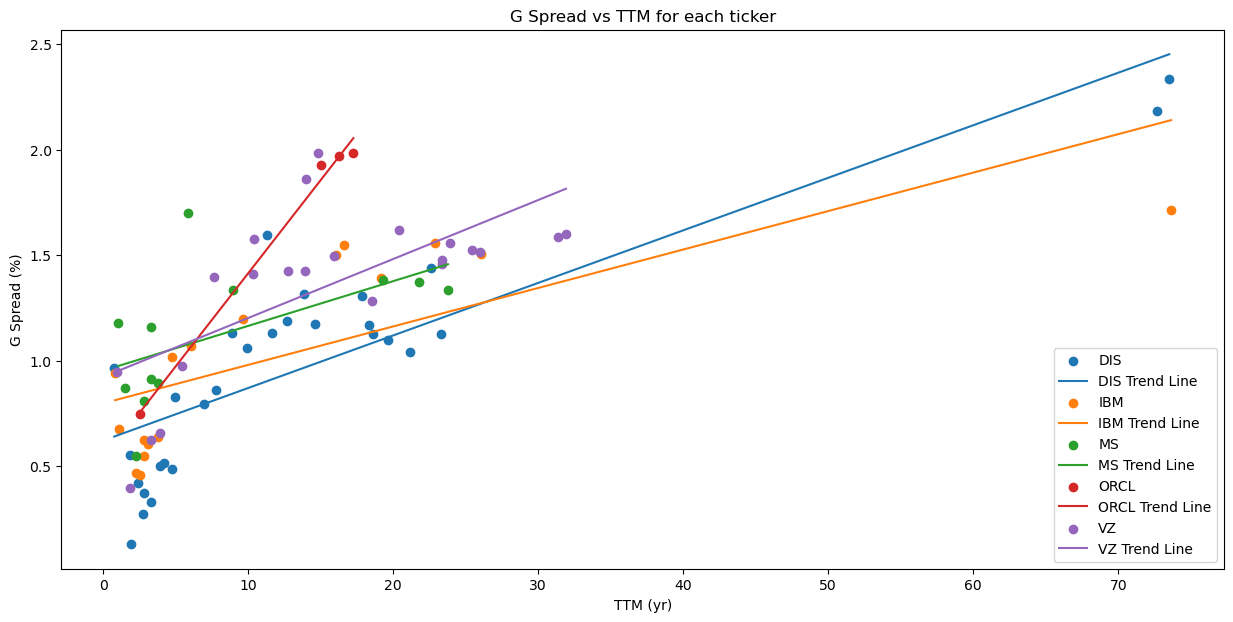

In [13]:
fig, ax = plt.subplots(figsize=(15, 7))
for ticker, group in corp_symbology_md.groupby('ticker'):
    ax.scatter(group['TTM'], group['g_spread'], label=ticker)
    #add best fit line
    z = np.polyfit(group['TTM'], group['g_spread'], 1)
    p = np.poly1d(z)
    plt.plot(group['TTM'], p(group['TTM']), label = f'{ticker} Trend Line')
ax.set_xlabel('TTM (yr)')
ax.set_ylabel('G Spread (%)')
ax.set_title('G Spread vs TTM for each ticker')
plt.legend()
plt.show()

### HW2Q1 - Constructing fixed rate bonds
1. Load the `govt_symbology` and `corp_symbology` Excel files into one common dataframe, using the `corp_symbology` columns. Filter the dataframe and keep fixed rate bonds only: (cpn_type="FIXED").
2. Add function to construct generic fixed rate cashflow schedules from symbology data.
   1. Use one row of the symbology dataframe as input  to the function. Use the helper function to convert a date string to a QuantLib date object. `get_ql_date(date_str)` , `create_schedule_from_symbology(row)`.
   2. Use one row of the symbology dataframe as input to the function. Use `create_schedule_from_symbology(row)` internally to create the cashflow schedule.
3. Add function that returns a dataframe with (future) cash flows details for a bond object - `get_bond_cashflows(bond, calc_date)`.

In [14]:
symbology = pd.concat([gov_otr_symbology_md, corp_symbology_md], ignore_index=True)
symbology

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,bid_yield,ask_yield,mid_yield,und_bench_isin,mty_typ,rank,und_bench_yield,credit_spread,interp_tsy_yield,g_spread
0,T,Govt,BBG01G14BXX2,US91282CGU99,TSRYS5557560,T 3 7/8 03/31/25,US TREASURY N/B,US GOVERNMENT,3.875,FIXED,...,4.105,4.099,4.1020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,T,Govt,BBG01G5ZMM43,US91282CGV72,TSRYS5565937,T 3 3/4 04/15/26,US TREASURY N/B,US GOVERNMENT,3.750,FIXED,...,3.836,3.831,3.8335,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,T,Govt,BBG01G14BW91,US91282CGT27,TSRYS5557562,T 3 5/8 03/31/28,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,3.609,3.606,3.6075,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,T,Govt,BBG01G14BV75,US91282CGS44,TSRYS5557563,T 3 5/8 03/31/30,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,3.563,3.553,3.5580,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,T,Govt,BBG01DVKBC66,US91282CGM73,TSRYS5533941,T 3 1/2 02/15/33,US TREASURY N/B,US GOVERNMENT,3.500,FIXED,...,3.519,3.513,3.5160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,VZ,Corp,BBG0083CP816,US92343VCM46,VZ4214177,VZ 5.012 08/21/54,VERIZON COMMUNICATIONS,GLOBAL,5.012,FIXED,...,5.367,5.275,5.3210,US912810TL26,AT MATURITY,Sr Unsecured,3.724,1.5970,3.737,1.5840
87,VZ,Corp,BBG009PNW578,US92343VCZ58,VZ4213475,VZ 4.672 03/15/55,VERIZON COMMUNICATIONS,GLOBAL,4.672,FIXED,...,5.380,5.295,5.3375,US912810TL26,AT MATURITY,Sr Unsecured,3.724,1.6135,3.737,1.6005
88,DIS,Corp,BBG00N55NLL7,USU25497BM60,DIS4809936,DIS 7.9 12/01/2095,WALT DISNEY COMPANY/THE,EURO-DOLLAR,7.900,FIXED,...,6.003,5.836,5.9195,US912810TL26,AT MATURITY,Sr Unsecured,3.724,2.1955,3.737,2.1825
89,DIS,Corp,BBG00N55NPV7,USU25497BN44,DIS4809937,DIS 8 1/4 10/17/2096,WALT DISNEY COMPANY/THE,EURO-DOLLAR,8.250,FIXED,...,6.120,6.021,6.0705,US912810TL26,AT MATURITY,Sr Unsecured,3.724,2.3465,3.737,2.3335


In [15]:
bond_tsy_1 = create_bond_from_symbology(symbology.iloc[1].to_dict())
get_bond_cashflows(bond_tsy_1, calc_date = ql.Date(14, 4, 2023))

,CashFlowDate,CashFlowYearFrac,CashFlowAmount
0,"October 15th, 2023",0.5,1.875
1,"April 15th, 2024",1.0,1.875
2,"October 15th, 2024",1.5,1.875
3,"April 15th, 2025",2.0,1.875
4,"October 15th, 2025",2.5,1.875
5,"April 15th, 2026",3.0,1.875
6,"April 15th, 2026",3.0,100.000


In [16]:
bond_corp_1 = create_bond_from_symbology(symbology[symbology["ticker"]=="IBM"].iloc[1].to_dict())
get_bond_cashflows(bond_corp_1, calc_date = ql.Date(14, 4, 2023))

,CashFlowDate,CashFlowYearFrac,CashFlowAmount
7,"May 15th, 2023",0.086111,1.5
8,"November 15th, 2023",0.586111,1.5
9,"May 15th, 2024",1.086111,1.5
10,"May 15th, 2024",1.086111,100.0


### HW2Q2 HW2Q3 -  US Treasury yield curve calibration (On-The-Runs) | Pricing and risk metrics for US Treasury bonds
1. Restrict the symbology + market data dataframe to on-the-run US treasury notes only (excluding Treasury Bills) and create the treasury bond objects.
2. Calibrate the on-the-run treasury yield curve (bootstrapping). The function below shows how to calibrate a smooth yield/discount factor curve from the on-the-run treasury dataframe. `calibrate_yield_curve_from_frame(calc_date, treasury_details, price_quote_column_name)`.
3. Create a graph/scatter plot of the newly computed mid yields by maturity.
4. Plot the discount factor curve up to the 30 years point, using a 6 months discretization grid.
5. US Treasury pricing on the calibrated discount factor curve. You will need to switch the bond_engine to use the new on-the-run treasury yield curve:
`bond_engine = ql.DiscountingBondEngine(treasury_yield_curve_mid_handle)`
6. Compute analytical DV01, Duration and Convexity for US on-the-run treasuries (using flat yield). Remember that DV01 = Dirty_Price * Duration
7. Compute scenario DV01, Duration and Convexity for US on-the-run treasuries (using calibrated yield curve)

In [17]:
symbology_md = pd.merge(symbology, md, on='figi', how='inner', suffixes=('', '_y'))
symbology_md_otr = symbology_md[symbology_md['isin'].isin(gov_otr['isin'])].reset_index(drop=True)

In [18]:
tsy_yield_curve = calibrate_yield_curve_from_frame(ql.Date(14, 4, 2023), symbology_md_otr, 'mid_clean')
tsy_yield_curve_handle = ql.YieldTermStructureHandle(tsy_yield_curve)

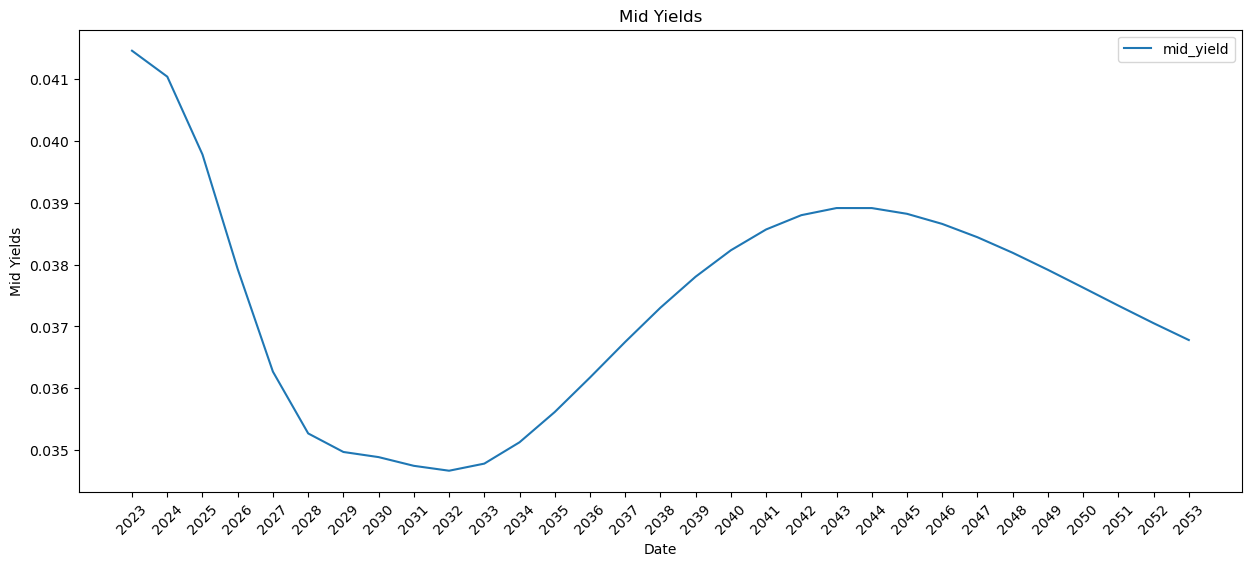

In [19]:
_ = plot_yield_curve(tsy_yield_curve, ql.Date(14, 4, 2023), ql.Date(14, 4, 2053), ql.ActualActual(ql.ActualActual.ISMA), 'US Treasury')

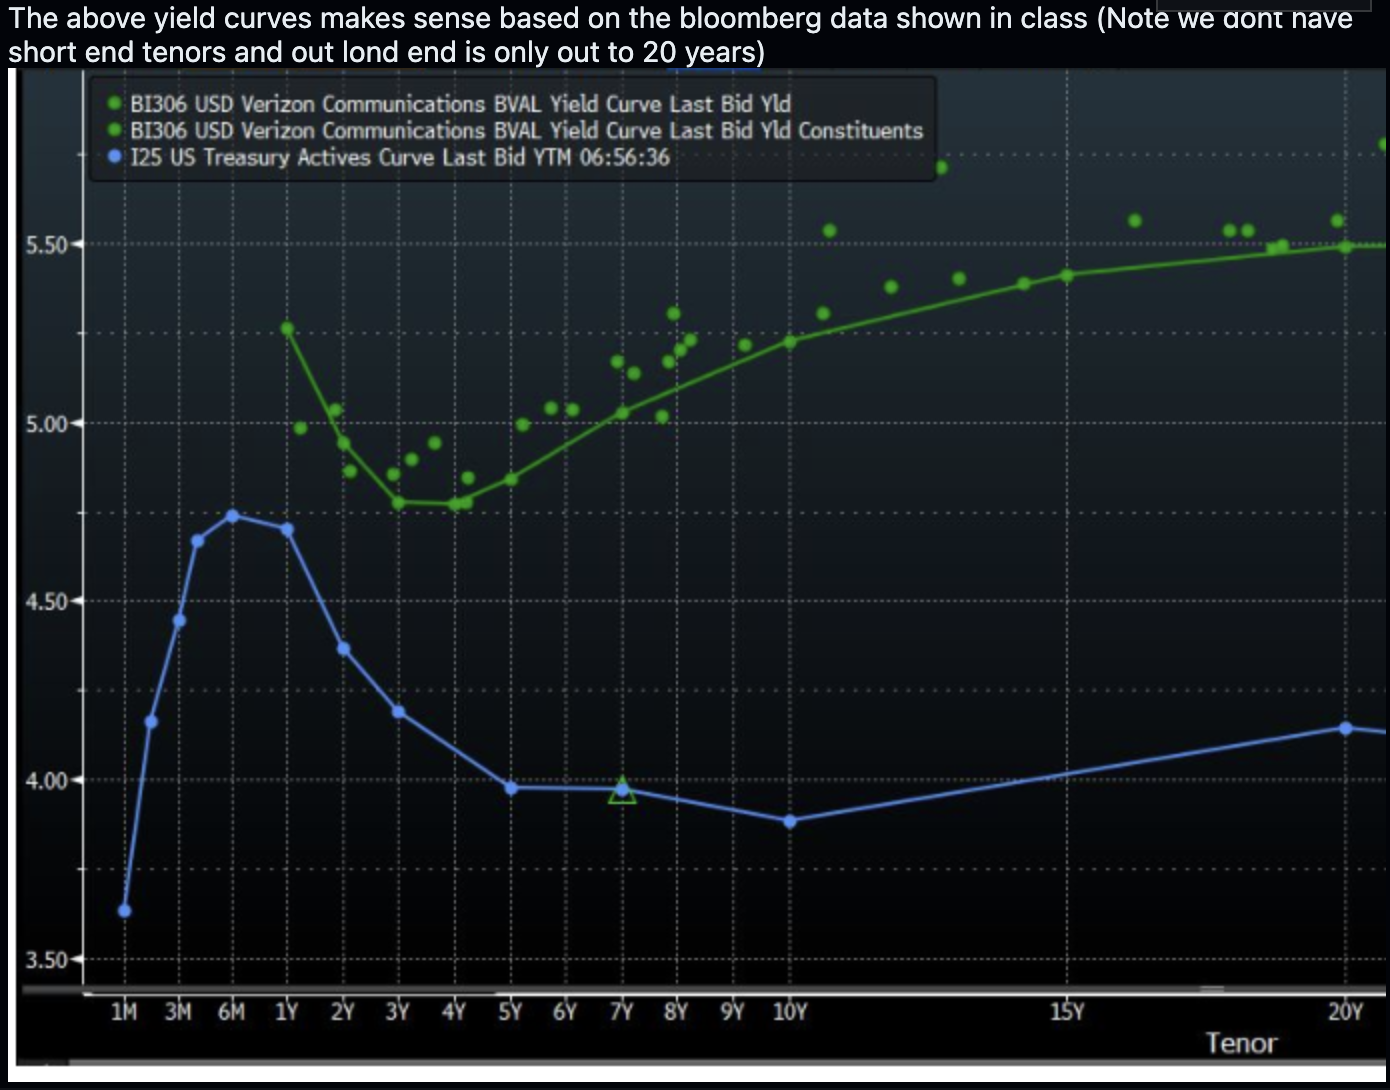

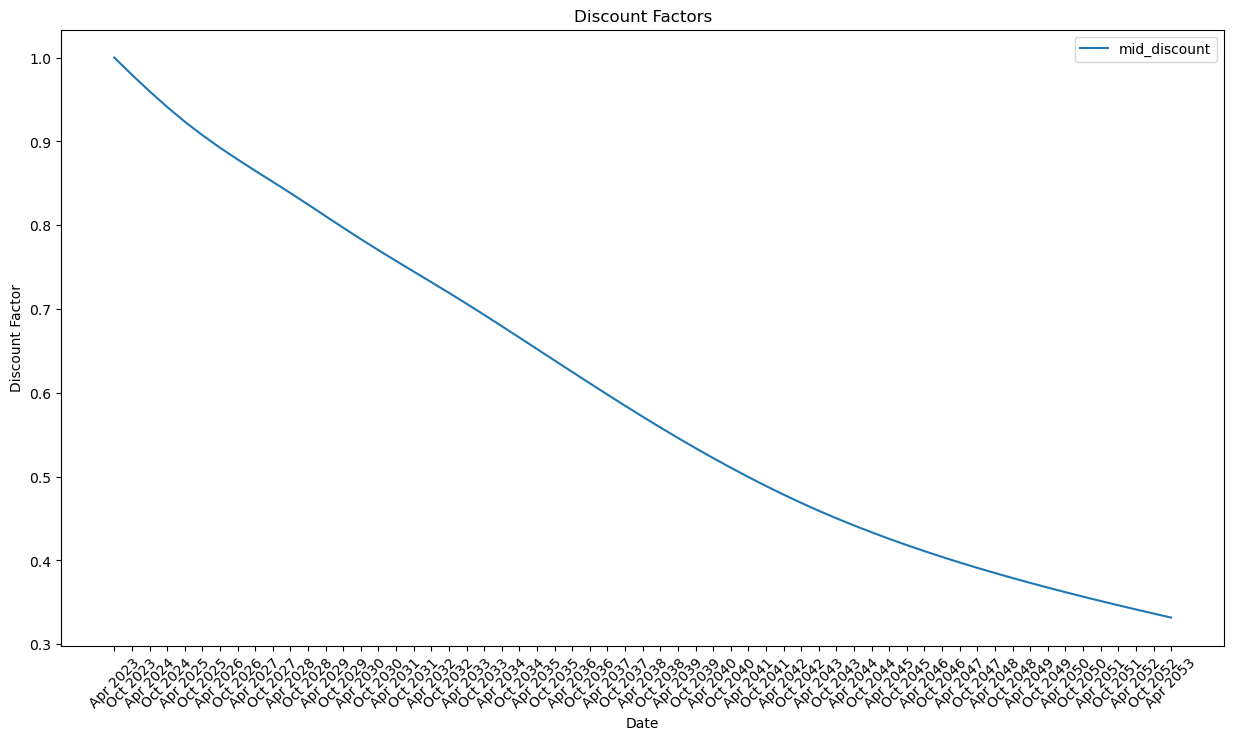

In [20]:
df_calib = plot_yield_curve(tsy_yield_curve, ql.Date(14, 4, 2023), ql.Date(14, 4, 2053), ql.ActualActual(ql.ActualActual.ISMA), 'US Treasury', CurveType="discount_6m")

### HW2Q4 - Pricing and risk metrics for corporate bonds
1. Create the on-the-run corporate bond objects
2. Compute analytical Yields and Z-Spreads
3. Validate Z-Spread computation for a few fixed rate corporate bonds
4. Compute Duration and Convexity for fixed rate corporate bonds (using flat yield)

In [21]:
bond_engine = ql.DiscountingBondEngine(tsy_yield_curve_handle)
symbology_md_otr_calib = price_bond(symbology_md_otr, bond_engine, ql.Date(14, 4, 2023))

In [22]:
symbology_md_otr_calib = calc_bond_metrics(symbology_md_otr_calib, ql.Date(14, 4, 2023), model="flat", coupon_freq=ql.Semiannual)

In [23]:
symbology_md_otr_calib = calc_bond_metrics(symbology_md_otr_calib, ql.Date(14, 4, 2023), model="yc", coupon_freq=ql.Semiannual, yc=tsy_yield_curve_handle)

drop all columns with '_y'

In [24]:
symbology_md_otr_calib = symbology_md_otr_calib.loc[:,~symbology_md_otr_calib.columns.str.endswith('_y')]

In [25]:
symbology_md_otr_calib

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,interp_tsy_yield,g_spread,mid_clean,calc_mid,dv01,duration,convexity,scen_dv01,scen_duration,scen_convexity
0,T,Govt,BBG01G14BXX2,US91282CGU99,TSRYS5557560,T 3 7/8 03/31/25,US TREASURY N/B,US GOVERNMENT,3.875,FIXED,...,NaN,NaN,99.5762,99.722292,1.845781,0.018503,4.386755,1.938457,0.019432,3.839399
1,T,Govt,BBG01G5ZMM43,US91282CGV72,TSRYS5565937,T 3 3/4 04/15/26,US TREASURY N/B,US GOVERNMENT,3.750,FIXED,...,NaN,NaN,99.7656,99.752188,2.781316,0.027873,9.353226,2.858789,0.028649,8.438682
2,T,Govt,BBG01G14BW91,US91282CGT27,TSRYS5557562,T 3 5/8 03/31/28,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,NaN,NaN,100.0781,100.212414,4.456410,0.044455,22.999615,4.631607,0.046202,22.416864
3,T,Govt,BBG01G14BV75,US91282CGS44,TSRYS5557563,T 3 5/8 03/31/30,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,NaN,NaN,100.4063,100.540502,6.042850,0.060084,41.925992,6.287876,0.062520,41.943021
4,T,Govt,BBG01DVKBC66,US91282CGM73,TSRYS5533941,T 3 1/2 02/15/33,US TREASURY N/B,US GOVERNMENT,3.500,FIXED,...,NaN,NaN,99.8672,100.422847,8.073575,0.080368,76.334006,8.401851,0.083636,77.559673
5,T,Govt,BBG01F6N6GN1,US912810TQ13,TSRYS5536898,T 3 7/8 02/15/43,US TREASURY N/B,US GOVERNMENT,3.875,FIXED,...,NaN,NaN,100.3359,100.954557,13.195321,0.130662,224.427402,14.012389,0.138753,239.626012
6,T,Govt,BBG01DVKBH56,US912810TN81,TSRYS5533944,T 3 5/8 02/15/53,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,NaN,NaN,97.9922,98.569540,16.157490,0.163863,387.768447,17.970860,0.182254,446.822403


### HW3Q1 - More details on callable bonds: "workout-date" and "yield-to-worst" calculations
1. Load the `call_schedules` Excel file into a dataframe. It contains call schedules for fixed-rate, callable corporate bonds.For each bond in the dataframe, compute the total number of outstanding calls.
2. Load symbology dataframe and extend it with the fixed-rate callable corporate bond details from 1a.
3. Add a function to compute "workout date" and "yield-to-worst" for a fixed-rate callable bond
4. Compute "workout dates" and "yields-to-worst" for all fixed-rate callable bonds.For each fixed-rate callable bond in the symbology dataframe from 1b (using calc_date = '2023-04-14' and clean market prices):
   1. Compute the yield to maturity 
   2. Use the function from 1c to compute "workout date" and "yield-to-worst".

In [26]:
call_schedules_df = pd.read_excel(os.path.join(mydir,'data', 'call_schedules.xlsx'))
call_schedules_count_df = call_schedules_df[['figi', 'call_date']].groupby(['figi']).count()
call_schedules_count_df.columns = ['num_call_dates']
call_schedules_count_df['num_call_dates'].value_counts()

1     99
16     1
Name: num_call_dates, dtype: int64

In [27]:
corp_symbology.to_clipboard()

In [28]:
combined_df = corp_symbology.merge(call_schedules_count_df, how='right', on=['figi'])
combined_df.head()

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,cpn_first,acc_first,maturity,mty_typ,rank,country,currency,term,TTM,num_call_dates
0,VZ,Corp,BBG003LZSS91,US92343VBG86,VZ3926361,US912810TQ13,VZ 3.85 11/01/42,VERIZON COMMUNICATIONS,GLOBAL,3.85,...,2013-05-01,2012-11-07,2042-11-01,CALLABLE,Sr Unsecured,US,USD,29.98,19.550992,1
1,ORCL,Corp,BBG006R54K79,US68389XAU90,ORCL4141352,US91282CGU99,ORCL 3.4 07/08/24,ORACLE CORP,GLOBAL,3.40,...,2015-01-08,2014-07-08,2024-07-08,CALLABLE,Sr Unsecured,US,USD,10.00,1.234771,1
2,ORCL,Corp,BBG006R54KG9,US68389XAV73,ORCL4141354,US91282CGM73,ORCL 4.3 07/08/34,ORACLE CORP,GLOBAL,4.30,...,2015-01-08,2014-07-08,2034-07-08,CALLABLE,Sr Unsecured,US,USD,20.00,11.233402,1
3,ORCL,Corp,BBG006R54KN1,US68389XAW56,ORCL4141355,US912810TQ13,ORCL 4 1/2 07/08/44,ORACLE CORP,GLOBAL,4.50,...,2015-01-08,2014-07-08,2044-07-08,CALLABLE,Sr Unsecured,US,USD,30.00,21.234771,1
4,VZ,Corp,BBG007DM0XF2,US92343VCR33,VZ4176696,US91282CGU99,VZ 3 1/2 11/01/24,VERIZON COMMUNICATIONS,GLOBAL,3.50,...,2015-05-01,2014-10-29,2024-11-01,CALLABLE,Sr Unsecured,US,USD,10.01,1.552361,1


In [29]:
# Use static calculation/valuation date of 2023-04-14, matching data available in the market prices EOD file
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

In [30]:
combined_df = corp_symbology.merge(md, how='inner', on=['class', 'ticker', 'isin', 'figi'])
# combined_df.set_index('figi',inplace=True)

# add yield_to_maturity
combined_df['clean_price'] = (combined_df['bid'] + combined_df['ask'])/2
combined_df['yield_to_maturity'] = (combined_df['bid_yield'] + combined_df['ask_yield'])/2

# add dummy workout_date & yield_to_worst columns, to be populated later
combined_df['workout_date'] = combined_df['date']
combined_df['yield_to_worst'] = 0

In [31]:
for row_index, row in combined_df.iterrows():
        
    details = row.to_dict()
        
    bond_clean_price = details['clean_price']
    
    workout_date, yield_to_worst = calc_yield_to_worst(details, call_schedules_df, bond_clean_price, calc_date)
    
    combined_df.loc[row_index, 'workout_date'] = workout_date
    combined_df.loc[row_index, 'yield_to_worst'] = yield_to_worst
          
# Show bonds with workout_date != maturity !!!
print('Bonds with workout_date < maturity (early call):')
combined_df[combined_df['maturity'] != combined_df['workout_date']][['isin', 'figi', 'ticker', 'security', 'clean_price', 'maturity', 'workout_date', 'yield_to_maturity', 'yield_to_worst']]

Found new workout date: BBG01BFF10D8 2029-11-09 00:00:00 2029-09-09 4.9745 4.973196983337403
Found new workout date: BBG01BFF10W7 2032-11-09 00:00:00 2032-08-09 5.2085 5.207163810729981
Found new workout date: BBG01BFF1128 2052-11-09 00:00:00 2052-05-09 6.042 6.041730356216429
Bonds with workout_date < maturity (early call):


,isin,figi,ticker,security,clean_price,maturity,workout_date,yield_to_maturity,yield_to_worst
128,US68389XCH61,BBG01BFF10D8,ORCL,ORCL 6.15 11/09/29,106.3700,2029-11-09,2029-09-09,4.9745,4.973197
129,US68389XCJ28,BBG01BFF10W7,ORCL,ORCL 6 1/4 11/09/32,107.6065,2032-11-09,2032-08-09,5.2085,5.207164
130,US68389XCK90,BBG01BFF1128,ORCL,ORCL 6.9 11/09/52,111.6810,2052-11-09,2052-05-09,6.0420,6.041730


### HW3Q3 - US SOFR swap curve calibration as of 2023-04-28
1. Load and explore US SOFR swaps symbology and market data
2. Load the `sofr_swap_symbology`. Load the `sofr_swaps_market_data_eod`. Plot the historial time series of SOFR rates for the available [1Y, 2Y, 3Y, 5Y, 7Y, 10Y, 20Y, 30Y] tenors.
3. Calibrate the US SOFR yield curve (via bootstrapping). Calibrate a smooth yield/discount factor curve from SOFR swaps.
4. Display the calibrated SOFR discount curve dataframe. Display the calibration details dataframe.
5. Plot the calibrated US SOFR Zero Interest Rates and Discount Factor curves. Plot the SOFR zero rates and discount factor curves by maturity

Text(0.5, 0, 'Date')

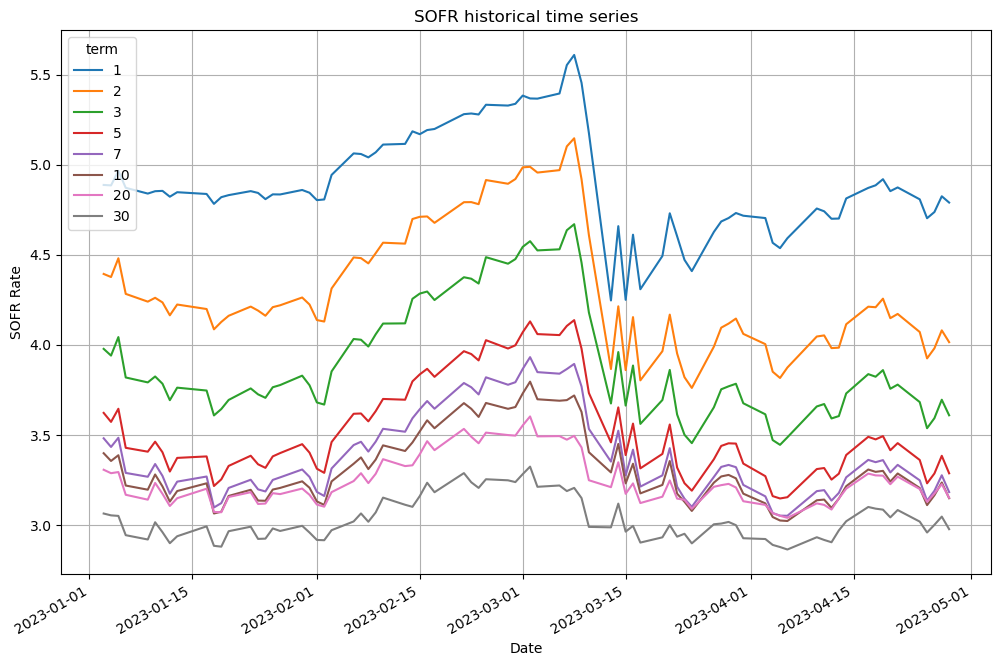

In [32]:
sofr_symbology_df = pd.read_excel(os.path.join(mydir,'data', 'sofr_swaps_symbology.xlsx'))
sofr_symbology_df.set_index('figi',inplace=True)

sofr_market_quotes_df = pd.read_excel(os.path.join(mydir,'data', 'sofr_swaps_market_data_eod.xlsx'))
sofr_market_quotes_df.columns = ['date', 'figi', 'mid_rate']

sofr_quotes_ts = sofr_market_quotes_df.pivot(index="date", columns="figi", values="mid_rate")
sofr_quotes_ts.columns = sofr_symbology_df.term[sofr_quotes_ts.columns]

plt = sofr_quotes_ts.plot(grid=True, style='-', title='SOFR historical time series', figsize=(12,8))
plt.set_ylabel('SOFR Rate')
plt.set_xlabel('Date')

In [33]:
calc_date = ql.Date(28, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

# combined_df
combined_df = sofr_symbology_df.merge(sofr_market_quotes_df[sofr_market_quotes_df['date'] == '2023-04-28'], how='left', on=['figi'])
print(combined_df.head())

# calibrate SOFR discount curve
sofr_yield_curve = calibrate_sofr_curve_from_frame(calc_date, combined_df, 'mid_rate')
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)


           figi   ticker   class             bbg                     name  \
0  BBG00KFWPJJ9  USOSFR1  Curncy  USOSFR1 Curncy  USD OIS  ANN VS SOFR 1Y   
1  BBG00KFWPJX3  USOSFR2  Curncy  USOSFR2 Curncy  USD OIS  ANN VS SOFR 2Y   
2  BBG00KFWPK15  USOSFR3  Curncy  USOSFR3 Curncy  USD OIS  ANN VS SOFR 3Y   
3  BBG00KFWPK51  USOSFR5  Curncy  USOSFR5 Curncy  USD OIS  ANN VS SOFR 5Y   
4  BBG00KFWPK79  USOSFR7  Curncy  USOSFR7 Curncy  USD OIS  ANN VS SOFR 7Y   

   term  type      dcc exchange country currency status       date  mid_rate  
0     1  SWAP  ACT/360     NONE      US      USD   ACTV 2023-04-28   4.79000  
1     2  SWAP  ACT/360     NONE      US      USD   ACTV 2023-04-28   4.01500  
2     3  SWAP  ACT/360     NONE      US      USD   ACTV 2023-04-28   3.60900  
3     5  SWAP  ACT/360     NONE      US      USD   ACTV 2023-04-28   3.28700  
4     7  SWAP  ACT/360     NONE      US      USD   ACTV 2023-04-28   3.18275  


In [34]:
# Display and plot SOFR yield curve
grid_dates = [sofr_yield_curve.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0,30,2))]


sofr_yield_curve_simple_df = get_yield_curve_details_df(sofr_yield_curve)                  # using calibration grid
sofr_yield_curve_details_df = get_yield_curve_details_df(sofr_yield_curve, grid_dates)    # using external grid

print(sofr_yield_curve_simple_df)
print(sofr_yield_curve_details_df)

         Date  YearFrac  DiscountFactor  ZeroRate
0  2023-05-02     0.000           1.000     4.788
1  2024-05-02     1.017           0.954     4.788
2  2025-05-02     2.031           0.923     3.998
3  2026-05-04     3.050           0.898     3.584
4  2028-05-02     5.075           0.850     3.256
5  2030-05-02     7.103           0.802     3.152
6  2033-05-02    10.147           0.732     3.123
7  2043-05-04    20.297           0.534     3.139
8  2053-05-02    30.439           0.419     2.899
          Date  YearFrac  DiscountFactor  ZeroRate
0   2023-05-02     0.000           1.000     4.788
1   2025-05-02     2.031           0.923     3.998
2   2027-05-02     4.058           0.872     3.420
3   2029-05-02     6.089           0.825     3.204
4   2031-05-02     8.117           0.778     3.142
5   2033-05-02    10.147           0.732     3.123
6   2035-05-02    12.175           0.687     3.126
7   2037-05-02    14.206           0.646     3.129
8   2039-05-02    16.233           0.606 

Text(0.5, 0, 'Date')

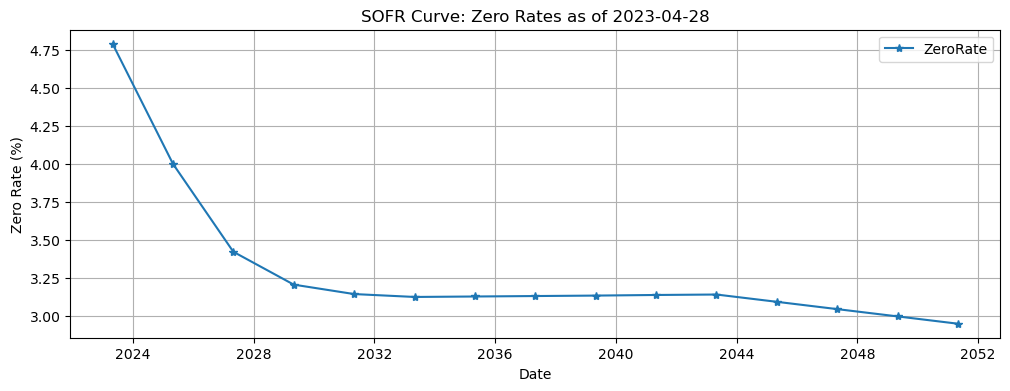

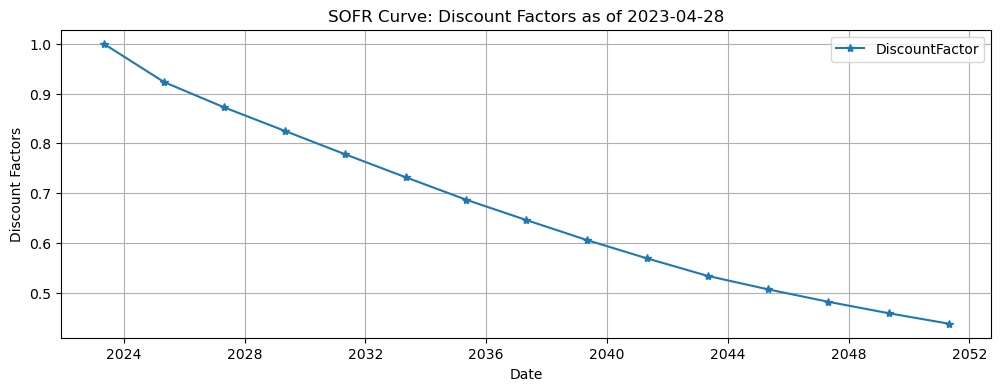

In [35]:
# Plot the SOFR yield curve
plt = sofr_yield_curve_details_df.plot(x='Date', y='ZeroRate', grid=True, style='*-', title='SOFR Curve: Zero Rates as of 2023-04-28', figsize=(12,4))
plt.set_ylabel('Zero Rate (%)')
plt.set_xlabel('Date')

plt = sofr_yield_curve_details_df.plot(x='Date', y='DiscountFactor', grid=True, style='*-', title='SOFR Curve: Discount Factors as of 2023-04-28', figsize=(12,4))
plt.set_ylabel('Discount Factors')
plt.set_xlabel('Date')

### HW3Q4 - CDS Hazard Rate calibration and valuation
1. Follow Section "12. CDS Hazard Rate calibration + Pricing" in the QuantLib Intro notebook. Load and explore the CDS market data. Plot the historical time series of CDS Par Spreads for the available tenors.
2. Calibrate the IBM hazard rate curve as of 2023-04-28. Follow section 12a. Use the calibrated SOFR discount curve from 2b.
3. Plot the calibrated Hazard Rates and Survival Probability curves. Follow section 12b. Use the calibrated SOFR discount curve from 2b.
4. Compute the fair/par spread and PV of a CDS. Follow section 12c. Construct a CDS object with 100 bps coupon and 2027-06-20 maturity. Compute the fair/par spread and PV.

           ticker                short_name    tier      sector  region  \
date                                                                      
2023-01-03    IBM  Intl Business Machs Corp  SNRFOR  Technology  N.Amer   
2023-01-04    IBM  Intl Business Machs Corp  SNRFOR  Technology  N.Amer   
2023-01-05    IBM  Intl Business Machs Corp  SNRFOR  Technology  N.Amer   
2023-01-06    IBM  Intl Business Machs Corp  SNRFOR  Technology  N.Amer   
2023-01-09    IBM  Intl Business Machs Corp  SNRFOR  Technology  N.Amer   

           currency doc_clause  running_coupon  cds_assumed_recovery  \
date                                                                   
2023-01-03      USD       XR14            0.01                   0.4   
2023-01-04      USD       XR14            0.01                   0.4   
2023-01-05      USD       XR14            0.01                   0.4   
2023-01-06      USD       XR14            0.01                   0.4   
2023-01-09      USD       XR14            

Text(0.5, 0, 'Date')

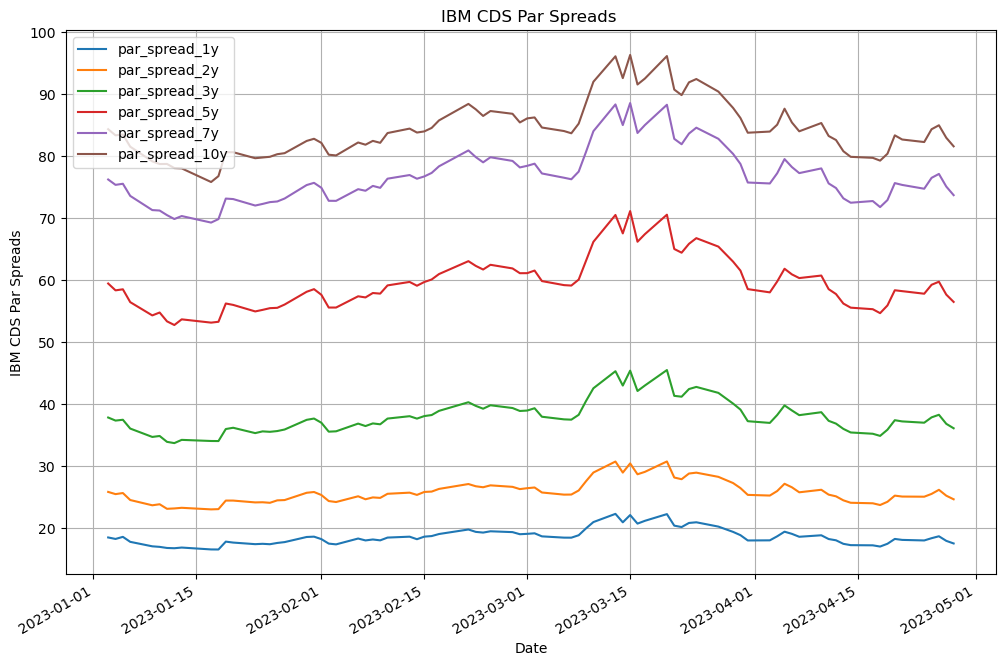

In [36]:
cds_market_quotes_df = pd.read_excel(os.path.join(mydir,'data', 'cds_market_data_eod.xlsx'))
cds_market_quotes_df.set_index('date',inplace=True)
print(cds_market_quotes_df.head())

# Create par spreads (bps) dataframe
par_spread_col_names = [f'par_spread_{n}y' for n in [1,2,3,5,7,10]]
cds_par_spreads_df = cds_market_quotes_df[par_spread_col_names].apply(lambda x: x*1e4)

plt = cds_par_spreads_df.plot(grid=True, style='-', title='IBM CDS Par Spreads ', figsize=(12,8))
plt.set_ylabel('IBM CDS Par Spreads')
plt.set_xlabel('Date')

In [37]:
# CDS spreads for IBM as of calc_date = 2023-04-28
cds_par_spreads = list(cds_par_spreads_df.loc['2023-04-28'])
print(cds_par_spreads)

# cds_recovery_rate
cds_recovery_rate = 0.4

# hazard_rate_curve
hazard_rate_curve = calibrate_cds_hazard_rate_curve(calc_date, sofr_yield_curve_handle, cds_par_spreads, cds_recovery_rate)

# hazard_rates_df
hazard_rates_df = get_hazard_rates_df(hazard_rate_curve, calc_date)
print(hazard_rates_df)


[17.523300000000003, 24.6527, 36.115, 56.5077, 73.7379, 81.6184]
         Date   YearFrac  HazardRateBps  SurvivalProb
0  2023-04-28   0.000000      28.904702      1.000000
1  2024-06-20   1.163889      28.904702      0.996641
2  2025-06-20   2.177778      55.007775      0.991098
3  2026-06-22   3.197222     103.201283      0.980726
4  2028-06-20   5.222222     152.860002      0.950833
5  2030-06-20   7.250000     208.525893      0.911466
6  2033-06-20  10.294444     174.980221      0.864181


Text(0.5, 0, 'Date')

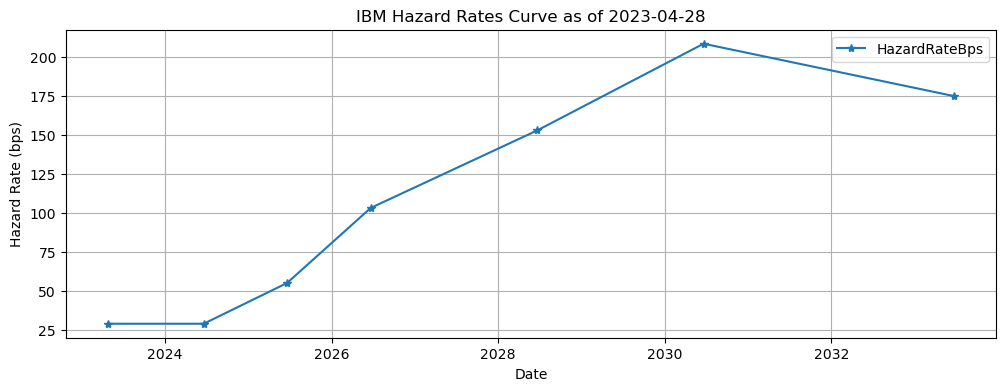

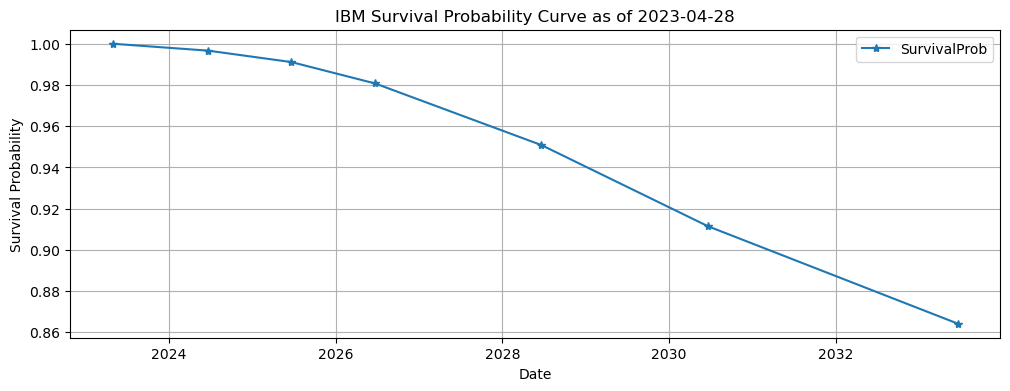

In [38]:
plt = hazard_rates_df.plot(x='Date', y='HazardRateBps', grid=True, style='*-', title='IBM Hazard Rates Curve as of 2023-04-28', figsize=(12,4))
plt.set_ylabel('Hazard Rate (bps)')
plt.set_xlabel('Date')

plt = hazard_rates_df.plot(x='Date', y='SurvivalProb', grid=True, style='*-', title='IBM Survival Probability Curve as of 2023-04-28', figsize=(12,4))
plt.set_ylabel('Survival Probability')
plt.set_xlabel('Date')


In [39]:
cds_maturity_date = ql.Date(20, 6, 2027)
cds_obj = create_cds_object(calc_date,cds_maturity_date)

# Create CDS pricing engine
default_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)
cds_engine = ql.MidPointCdsEngine(default_prob_curve_handle, cds_recovery_rate, sofr_yield_curve_handle)
cds_obj.setPricingEngine(cds_engine)

print('CDS protection start date:', cds_obj.protectionStartDate())
print('CDS fair/par spread:', round(cds_obj.fairSpread()*10000, 3))
print('CDS PV:', round(cds_obj.NPV(), 4))    
print('CDS Premium Leg PV:', round(cds_obj.couponLegNPV(), 4))
print('CDS Default Leg PV', round(cds_obj.defaultLegNPV(), 4))
print('Survival Prob. to Maturity:', round(hazard_rate_curve.survivalProbability(cds_maturity_date), 4))

CDS protection start date: April 28th, 2023
CDS fair/par spread: 48.65
CDS PV: 1.968
CDS Premium Leg PV: 3.8325
CDS Default Leg PV -1.8645
Survival Prob. to Maturity: 0.9657


### HW4Q1 - Pricing risky bonds in the hazard rate model
1. Calibrate the following curves as of 2023-04-14:
- the "on-the-run" US Treasury curve,
- the US SOFR curve and 
- the IBM CDS hazard rate curve (on the top of SOFR discount curve).
2. Create the corresponding fixed rate bonds. Use the create_bond_from_symbology() function. List the bond cashflows using the get_bond_cashflows() function.
3. Compute CDS-implied (intrinsic) prices for the IBM fixd rate bonds. Price the bonds using the CDS-calibrated hazard rate curve (via RiskyBondEngine)
4. Compute the "intrinsic" vs market price basis for the bonds. Load the market clean prices and yields (mid quotes) from the market quotes dataframe as of 2023-04-14. Compute the basis between the "CDS-implied intrinsic" vs market values. 
- BasisInPrice = corpBondModelPrice - corpBondMarketPrice
- BasisInYield = corpBondModelYield - corpBondMarketYield

In [40]:
calc_date = ql.Date(14, 4, 2023)
calc_date_str = '2023-04-14'
ql.Settings.instance().evaluationDate = calc_date

In [41]:
###################################################
# Prepare the "on-the-run" US Treasury dataframe
###################################################

# govt_symbology_df
govt_symbology_df = pd.read_excel(os.path.join(mydir,'data', 'govt_symbology.xlsx'))
govt_symbology_df.set_index('figi',inplace=True)

# govt_otr_df
govt_otr_df = pd.read_excel(os.path.join(mydir,'data', 'govt_on_the_run.xlsx'))
govt_otr_df.set_index('ticker',inplace=True)

# filter for on_the_run_tsy_tickers
on_the_run_tsy_tickers = ['GT2 Govt', 'GT3 Govt', 'GT5 Govt', 'GT7 Govt', 'GT10 Govt', 'GT20 Govt', 'GT30 Govt']
on_the_run_tsy_figis = govt_otr_df.loc[on_the_run_tsy_tickers]['figi']

# govt_otr_symbology_df
govt_otr_symbology_df = govt_symbology_df.loc[on_the_run_tsy_figis]
# print(govt_otr_symbology_df)

# market_prices_df
market_prices_df = pd.read_excel(os.path.join(mydir,'data', 'market_prices_eod.xlsx'))
market_prices_df.set_index('date',inplace=True)

# treasury_otr_df
treasury_otr_df = govt_otr_symbology_df.merge(market_prices_df.loc[calc_date_str], how='left', on=['figi', 'class', 'ticker', 'isin'])
treasury_otr_df.sort_values('maturity',inplace=True)
print(treasury_otr_df[['figi', 'security', 'bid', 'ask', 'bid_yield', 'bid_yield']])


           figi          security       bid       ask  bid_yield  bid_yield
0  BBG01G14BXX2  T 3 7/8 03/31/25   99.5703   99.5820      4.105      4.105
1  BBG01G5ZMM43  T 3 3/4 04/15/26   99.7578   99.7734      3.836      3.836
2  BBG01G14BW91  T 3 5/8 03/31/28  100.0703  100.0859      3.609      3.609
3  BBG01G14BV75  T 3 5/8 03/31/30  100.3750  100.4375      3.563      3.563
4  BBG01DVKBC66  T 3 1/2 02/15/33   99.8438   99.8906      3.519      3.519
5  BBG01F6N6GN1  T 3 7/8 02/15/43  100.2969  100.3750      3.853      3.853
6  BBG01DVKBH56  T 3 5/8 02/15/53   97.9531   98.0313      3.739      3.739


In [42]:
###################################################
# Load SOFR symbology and market data quotes
###################################################

# sofr_symbology_df
sofr_symbology_df = pd.read_excel(os.path.join(mydir,'data', 'sofr_swaps_symbology.xlsx'))

# sofr_market_quotes_df
sofr_market_quotes_df = pd.read_excel(os.path.join(mydir,'data', 'sofr_swaps_market_data_eod.xlsx'))
sofr_market_quotes_df.set_index('date',inplace=True)
sofr_market_quotes_df.columns = ['figi', 'mid_rate']
# print(sofr_market_quotes_df.tail())

# sofr_df
sofr_df = sofr_symbology_df.merge(sofr_market_quotes_df.loc[calc_date_str], how='left', on=['figi'])
print(sofr_df[['figi', 'name', 'mid_rate']])


           figi                      name  mid_rate
0  BBG00KFWPJJ9   USD OIS  ANN VS SOFR 1Y   4.81290
1  BBG00KFWPJX3   USD OIS  ANN VS SOFR 2Y   4.11450
2  BBG00KFWPK15   USD OIS  ANN VS SOFR 3Y   3.73035
3  BBG00KFWPK51   USD OIS  ANN VS SOFR 5Y   3.38865
4  BBG00KFWPK79   USD OIS  ANN VS SOFR 7Y   3.26475
5  BBG00KFWPKB4  USD OIS  ANN VS SOFR 10Y   3.21550
6  BBG00KFWPKF0  USD OIS  ANN VS SOFR 20Y   3.20165
7  BBG00KFWPKH8  USD OIS  ANN VS SOFR 30Y   3.02075


In [43]:
# cds_market_quotes_df
cds_market_quotes_df = pd.read_excel(os.path.join(mydir,'data', 'cds_market_data_eod.xlsx'))
cds_market_quotes_df.set_index('date',inplace=True)
# print(cds_market_quotes_df.head())

# Create par spreads (bps) dataframe
par_spread_col_names = [f'par_spread_{n}y' for n in [1,2,3,5,7,10]]
cds_market_quotes_df = cds_market_quotes_df[par_spread_col_names].apply(lambda x: x*1e4)


In [44]:
# tsy_yield_curve calibration
tsy_yield_curve = calibrate_yield_curve_from_frame(calc_date, treasury_otr_df, 'mid_clean')
tsy_yield_curve_handle = ql.YieldTermStructureHandle(tsy_yield_curve)


# sofr_yield_curve calibration
sofr_yield_curve = calibrate_sofr_curve_from_frame(calc_date, sofr_df, 'mid_rate')
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)


# hazard_rate_curve calibration (from IBM CDS par spreads)
cds_par_spreads = list(cds_market_quotes_df.loc[calc_date_str])
cds_recovery_rate = 0.4

# hazard_rate_curve
hazard_rate_curve = calibrate_cds_hazard_rate_curve(calc_date, sofr_yield_curve_handle, cds_par_spreads, cds_recovery_rate)
default_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)

In [45]:
# corp_symbology_df
corp_symbology_df = pd.read_excel(os.path.join(mydir,'data', 'corp_symbology.xlsx'))
corp_symbology_df = corp_symbology_df[corp_symbology_df.cpn_type == 'FIXED']
ibm_symbology_df = corp_symbology_df[corp_symbology_df.ticker == 'IBM']

# market_prices_df
market_prices_df = pd.read_excel(os.path.join(mydir,'data', 'market_prices_eod.xlsx'))
# market_prices_df.set_index('figi',inplace=True)

# ibm_df
ibm_df = ibm_symbology_df.merge(market_prices_df, how='inner', on=['class', 'ticker', 'isin', 'figi'])
ibm_df.set_index('figi',inplace=True)

# Keep selected IBM bonds only
ibm_selected_figis = ['BBG00P3BLH05', 'BBG00FVNGFP3', 'BBG00P3BLH14']
ibm_df = ibm_df.loc[ibm_selected_figis]
print(ibm_df.T)


figi                   BBG00P3BLH05         BBG00FVNGFP3         BBG00P3BLH14
ticker                          IBM                  IBM                  IBM
class                          Corp                 Corp                 Corp
isin                   US459200JZ55         US459200JR30         US459200KA85
trace                    IBM4832194           IBM4448403           IBM4832195
und_bench_isin         US91282CGR60         US91282CGT27         US91282CGT27
security           IBM 3.3 05/15/26     IBM 3.3 01/27/27   IBM 3 1/2 05/15/29
name                       IBM CORP             IBM CORP             IBM CORP
type                         GLOBAL               GLOBAL               GLOBAL
coupon                          3.3                  3.3                  3.5
cpn_type                      FIXED                FIXED                FIXED
dcc                          30/360               30/360               30/360
cpn_freq                          2                    2        

In [46]:
# Create ibm_bond_objects
ibm_bond_objects = [ create_bond_from_symbology(df_row.to_dict()) for index, df_row in ibm_df.iterrows()]

# List the bond cashflows
for i in range(0, 3):
    print('Bond cashflows for', ibm_df.iloc[i]['security'])
    print(get_bond_cashflows(ibm_bond_objects[i], calc_date)) 


Bond cashflows for IBM 3.3 05/15/26
           CashFlowDate  CashFlowYearFrac  CashFlowAmount
7        May 15th, 2023          0.086111            1.65
8   November 15th, 2023          0.586111            1.65
9        May 15th, 2024          1.086111            1.65
10  November 15th, 2024          1.586111            1.65
11       May 15th, 2025          2.086111            1.65
12  November 15th, 2025          2.586111            1.65
13       May 15th, 2026          3.086111            1.65
14       May 15th, 2026          3.086111          100.00
Bond cashflows for IBM 3.3 01/27/27
          CashFlowDate  CashFlowYearFrac  CashFlowAmount
12     July 27th, 2023          0.286111            1.65
13  January 27th, 2024          0.786111            1.65
14     July 27th, 2024          1.286111            1.65
15  January 27th, 2025          1.786111            1.65
16     July 27th, 2025          2.286111            1.65
17  January 27th, 2026          2.786111            1.65
18     

In [47]:
# flat_recovery_rate
flat_recovery_rate = 0.40

# Risky bond engine uses the calibrated CDS hazard rate curve for pricing credit default risk 
risky_bond_engine = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle)

# Model/intrinsic prices and yields
ibm_model_prices = []
ibm_model_yields = []

# Print the clean prices and yields for the 3 test bonds
for i in range(0, 3):
    fixed_rate_bond = ibm_bond_objects[i]
    fixed_rate_bond.setPricingEngine(risky_bond_engine)
    
    corpBondModelPrice = round(fixed_rate_bond.cleanPrice(), 3)
    corpBondModelYield = round(fixed_rate_bond.bondYield(corpBondModelPrice, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100, 3)

    ibm_model_prices.append(corpBondModelPrice)
    ibm_model_yields.append(corpBondModelYield)
    
    
# Display relevant metrics
ibm_df['model_price'] = ibm_model_prices
ibm_df['model_yield'] = ibm_model_yields
print(ibm_df[['security', 'model_price', 'model_yield']])


                        security  model_price  model_yield
figi                                                      
BBG00P3BLH05    IBM 3.3 05/15/26       97.494        4.176
BBG00FVNGFP3    IBM 3.3 01/27/27       96.910        4.192
BBG00P3BLH14  IBM 3 1/2 05/15/29       96.224        4.210


In [48]:
# Add market prices
ibm_df['market_price'] = (ibm_df['bid'] + ibm_df['ask']) / 2
ibm_df['market_yield'] = (ibm_df['bid_yield'] + ibm_df['ask_yield']) / 2

# Compute basis
ibm_df['basis_price'] = ibm_df['model_price'] - ibm_df['market_price']
ibm_df['basis_yield'] = ibm_df['model_yield'] - ibm_df['market_yield']

# Display relevant metrics
print(ibm_df[['security', 'market_price', 'model_price', 'basis_price', 'market_yield', 'model_yield', 'basis_yield']])

                        security  market_price  model_price  basis_price  \
figi                                                                       
BBG00P3BLH05    IBM 3.3 05/15/26       96.7870       97.494       0.7070   
BBG00FVNGFP3    IBM 3.3 01/27/27       96.2695       96.910       0.6405   
BBG00P3BLH14  IBM 3 1/2 05/15/29       93.9720       96.224       2.2520   

              market_yield  model_yield  basis_yield  
figi                                                  
BBG00P3BLH05         4.428        4.176       -0.252  
BBG00FVNGFP3         4.382        4.192       -0.190  
BBG00P3BLH14         4.650        4.210       -0.440  


### HW4Q2 - Compute scenario sensitivities for risky bonds
1. Compute scenario IR01s for the bonds. Compute the scenario IR01 and Durations using a -1bp interest rate shock, as described in Section 6. "Market Data Scenarios" in the QuantLib introductory notebook.
- IR01 = Dirty_Price * Duration
2. Compute scenario Convexities for the bonds. Compute the scenario Convexities using the +/-1bp interest rate shocks.
3. Compute scenario HR01s (hazard rate sensitivity) and CS01s (credit spread sensitivity) for the bonds. Apply a -1bp (parallel shift) scenario to the IBM CDS Par Spread quotes and calibrate the scenario hazard rate curve. Create a new scenario RiskyBondEngine, using the scenario hazard rate curve. Reprice the risky bonds on the scenario RiskyBondEngine (using the bumped hazard rate curve) to obtain the -1bp scenario HR01 (hazard rate sensitivity).
4. The credit spread sensitivity CS01 is defined as CS01 = (ScenarioPrice - BasePrice) / (ScenarioYield - BasePYield) * 100.
5. Compute scenario Rec01 (recovery rate sensitivity) for the bonds. Apply a +1% scenario bump to the IBM recovery rate (flat_recovery_rate parameter will move from 40% to 41%). Create a new scenario RiskyBondEngine, using the scenario new recovery rate. Reprice the risky bonds on the scenario RiskyBondEngine (using the bumped recovery rate) to obtain the +1% scenario REC01 (recovery rate sensitivity).

In [49]:
calc_scenario_sensi(calc_date,ibm_df, tsy_yield_curve_handle, default_prob_curve_handle,cds_par_spreads,sofr_yield_curve_handle, flat_recovery_rate=0.4,flat_rec_bump=0)

,ticker,class,isin,trace,und_bench_isin,security,name,type,coupon,cpn_type,...,basis_price,basis_yield,IRO1,Duration,Convexity,Analytic Duration,Analytic Convexity,HR01,CS01,Rec01
figi,,,,,,,,,,,,,,,,,,,,,
BBG00P3BLH05,IBM,Corp,US459200JZ55,IBM4832194,US91282CGR60,IBM 3.3 05/15/26,IBM CORP,GLOBAL,3.3,FIXED,...,0.7070,-0.252,2.861644,2.893576,8.147527,2.846346,9.823037,2.846314,2.901598,0.016768
BBG00FVNGFP3,IBM,Corp,US459200JR30,IBM4448403,US91282CGT27,IBM 3.3 01/27/27,IBM CORP,GLOBAL,3.3,FIXED,...,0.6405,-0.190,3.501088,3.585249,14.900701,3.478820,14.302625,3.508677,3.505292,0.025761
BBG00P3BLH14,IBM,Corp,US459200KA85,IBM4832195,US91282CGT27,IBM 3 1/2 05/15/29,IBM CORP,GLOBAL,3.5,FIXED,...,2.2520,-0.440,5.256227,5.379333,31.611894,5.316407,33.104126,5.456637,5.334841,0.057841


### HW4Q3 - Nelson-Siegel model for smooth hazard rate curves
1. Follow Lecture 4, Section 1 "Parametric Hazard Rate Models", Follow Section "13. Smooth parametric yield and hazard rate curves: the Nelson-Siegel model" in the QuantLib Intro V3 notebook
2. Load the symbology + market data dataframes.
3. Calibrate the "on-the-run" US Treasury curve, which will be used as discount factor curve
4. Create the Nelson-Siegel curve shape (4 parameters) and compute the corresponding SSE function.
   1. For a given set of parameters, write a function to compute the SSE "Sum of Squared Errors" penalty function in price space (defined as sum of squared differences between model and market prices for all Verizon fixed-rate bonds).
   2. For each bond, compute the bond durations, using Section "9. Analytical Duration" in the QuantLib introductory notebook as a template.
   3. Use 1/Duration as SSE weights. You can ignore the liquidity adjuster for the purpose of this exercise.
5. Calibrate the Nelson-Siegel model parameters to obtain the smooth Verizon credit curve.
   1. Minimize the SSE (pricing error) function to obtain the optimal/calibrated Nelson-Siegel parameter vector. 
   2. Create the calibrated/smooth credit curve corresponding to the optimal model parameters.
6. Compute smooth model prices, yields and "edges"
   1. Price all Verizon bonds on the calibrated credit curve and compute the corresponding yields.
   2. Plot the model vs market yields (Y-axis) by time to maturity (X-axis).
   3. Plot the edges in yield space (Y-axis) by time to maturity (X-axis).

In [50]:
# vz_symbology_df
vz_symbology_df = corp_symbology_df[corp_symbology_df.ticker == 'VZ']
# vz_df
vz_df = vz_symbology_df.merge(market_prices_df, how='inner', on=['class', 'ticker', 'isin', 'figi'])
vz_df['market_price'] = vz_df['mid_clean']
vz_df['market_yield'] = (vz_df['bid_yield'] + vz_df['ask_yield']) / 2
vz_df.sort_values('maturity',inplace=True)
vz_df.head()

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,currency,date,bid,ask,mid_clean,mid_dirty,bid_yield,ask_yield,market_price,market_yield
40,VZ,Corp,BBG00ZLKTDJ4,US92343VGF58,VZ5148416,US91282CGU99,VZ 0 3/4 03/22/24,VERIZON COMMUNICATIONS,GLOBAL,0.750,...,USD,2023-04-14,95.975,96.327,96.151,96.205,5.251,4.846,96.151,5.0485
9,VZ,Corp,BBG007DM0XF2,US92343VCR33,VZ4176696,US91282CGU99,VZ 3 1/2 11/01/24,VERIZON COMMUNICATIONS,GLOBAL,3.500,...,USD,2023-04-14,98.169,98.352,98.261,99.885,4.749,4.623,98.261,4.6860
21,VZ,Corp,BBG00JKZK9K4,US92343VEN01,VZ4581325,US91282CGU99,VZ 3.376 02/15/25,VERIZON COMMUNICATIONS,GLOBAL,3.376,...,USD,2023-04-14,97.932,98.164,98.048,98.639,4.567,4.432,98.048,4.4995
32,VZ,Corp,BBG00Y4Q8VY9,US92343VFS88,VZ5078182,US91282CGU99,VZ 0.85 11/20/25,VERIZON COMMUNICATIONS,GLOBAL,0.850,...,USD,2023-04-14,91.109,91.440,91.274,91.623,4.528,4.383,91.274,4.4555
41,VZ,Corp,BBG00ZLKTF09,US92343VGG32,VZ5148417,US91282CGR60,VZ 1.45 03/20/26,VERIZON COMMUNICATIONS,GLOBAL,1.450,...,USD,2023-04-14,91.806,92.127,91.967,92.080,4.472,4.348,91.967,4.4100


In [51]:
# bond_recovery_rate
bond_recovery_rate = 0.4

# initial_nelson_siegel_params
initial_nelson_siegel_params = [0.03, -0.01, 0.02, 5.0]

fixed_rate_bond_objects, calib_weights, bond_market_prices, bond_yields, bond_DV01s, bond_durations = create_bonds_and_weights(vz_df, tsy_yield_curve_handle)

vz_df['duration'] = bond_durations
vz_df['calib_weight'] = calib_weights

init_bond_model_prices, init_bond_model_yields = calculate_nelson_siegel_model_prices_and_yields(initial_nelson_siegel_params, calc_date, fixed_rate_bond_objects, tsy_yield_curve_handle, bond_recovery_rate)
vz_df['init_model_price'] = init_bond_model_prices
vz_df['init_model_yield'] = init_bond_model_yields
print(vz_df[['security', 'market_price', 'init_model_price', 'calib_weight']].head())

# initial_sse
initial_sse = nelson_siegel_sse(initial_nelson_siegel_params, calc_date, fixed_rate_bond_objects, bond_market_prices, calib_weights, tsy_yield_curve_handle, bond_recovery_rate)
print('initial_sse =', initial_sse)

             security  market_price  init_model_price  calib_weight
40  VZ 0 3/4 03/22/24        96.151         95.809946      0.045628
9   VZ 3 1/2 11/01/24        98.261         96.841448      0.045628
21  VZ 3.376 02/15/25        98.048         96.262144      0.045628
32   VZ 0.85 11/20/25        91.274         89.078877      0.036516
41   VZ 1.45 03/20/26        91.967         89.459038      0.032556
initial_sse = 10.417281362572574


In [52]:
# calibrate_nelson_siegel_model
calib_results = calibrate_nelson_siegel_model(initial_nelson_siegel_params, calc_date, vz_df, tsy_yield_curve_handle, bond_recovery_rate)
print(calib_results)
    
# calib_nelson_siegel_params
calib_nelson_siegel_params = calib_results.x
print('calib_nelson_siegel_params:', calib_nelson_siegel_params)

# calib_nelson_siegel_curve
calib_nelson_siegel_curve = create_nelson_siegel_curve(calc_date, calib_nelson_siegel_params)

# calib_sse
calib_sse = nelson_siegel_sse(calib_nelson_siegel_params, calc_date, fixed_rate_bond_objects, bond_market_prices, calib_weights, tsy_yield_curve_handle, bond_recovery_rate)
print('initial_sse =', round(initial_sse, 3), 'calib_sse =', round(calib_sse, 3))


      fun: 6.301656061274093
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.15862883e-03,  7.03970215e-04,  4.94448926e-04, -9.85878052e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 285
      nit: 41
     njev: 57
   status: 0
  success: True
        x: array([ 4.27286184e-02, -5.55962988e-02, -3.75669033e-06,  2.68681784e+00])
calib_nelson_siegel_params: [ 4.27286184e-02 -5.55962988e-02 -3.75669033e-06  2.68681784e+00]
initial_sse = 10.417 calib_sse = 6.302


In [53]:
# bond_model_prices
bond_model_prices, bond_model_yields = calculate_nelson_siegel_model_prices_and_yields(calib_nelson_siegel_params, calc_date, fixed_rate_bond_objects, tsy_yield_curve_handle, bond_recovery_rate)
vz_df['model_price'] = bond_model_prices
vz_df['model_yield'] = bond_model_yields
vz_df['edge_price'] = vz_df['model_price'] - vz_df['market_price']
vz_df['edge_yield'] = vz_df['model_yield'] - vz_df['market_yield']

print(vz_df[['security', 'market_price','init_model_price', 'model_price', 'edge_price']].tail())
print(vz_df[['security', 'market_yield','init_model_yield', 'model_yield', 'edge_yield']].tail())

             security  market_price  init_model_price  model_price  edge_price
7   VZ 5.012 08/21/54        95.309         91.657108    90.642132   -4.666868
12  VZ 4.672 03/15/55        89.855         87.324579    86.235978   -3.619022
36  VZ 2.987 10/30/56        64.251         65.434541    64.181636   -0.069364
35      VZ 3 11/20/60        63.355         65.042687    63.716480    0.361480
39    VZ 3.7 03/22/61        73.893         74.323778    72.955087   -0.937913
             security  market_yield  init_model_yield  model_yield  edge_yield
7   VZ 5.012 08/21/54        5.3210          5.577828     5.652060    0.331060
12  VZ 4.672 03/15/55        5.3375          5.520859     5.602438    0.264938
36  VZ 2.987 10/30/56        5.2700          5.166936     5.275935    0.005935
35      VZ 3 11/20/60        5.2410          5.098348     5.209905   -0.031095
39    VZ 3.7 03/22/61        5.3055          5.271884     5.378757    0.073257


Text(0.5, 0, 'Bond Maturity')

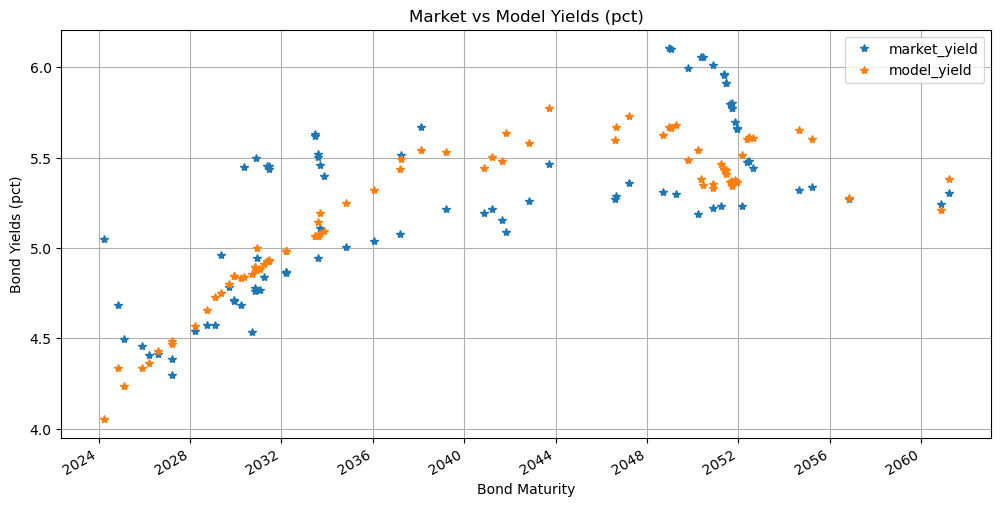

In [54]:
plt = vz_df.plot(x='maturity', y = ['market_yield', 'model_yield'], figsize = (12, 6), title = "Market vs Model Yields (pct)", grid=True, style='*')
plt.set_ylabel('Bond Yields (pct)')
plt.set_xlabel('Bond Maturity')


Text(0.5, 0, 'Bond Maturity')

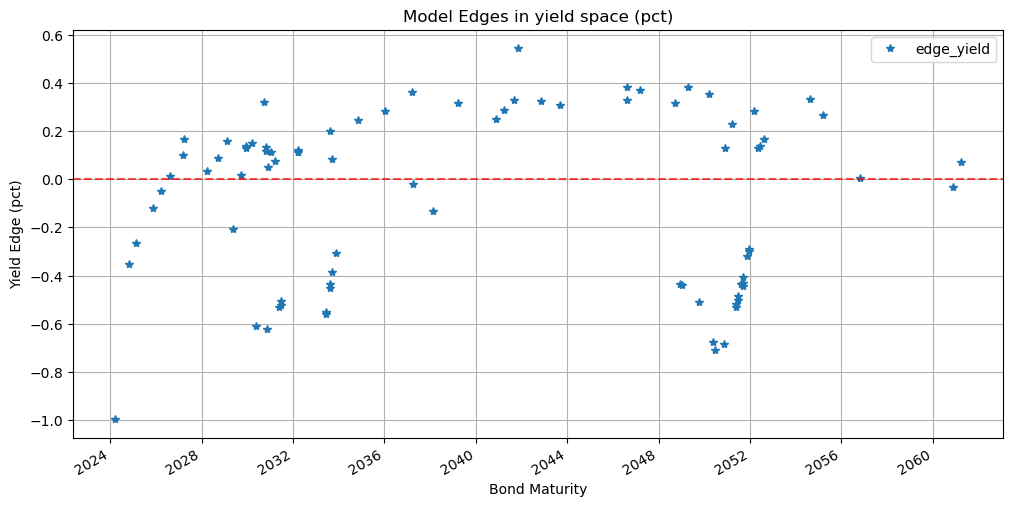

In [55]:
plt = vz_df.plot(x='maturity', y = ['edge_yield'], figsize = (12, 6), title = "Model Edges in yield space (pct)", grid=True, style='*')
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.set_ylabel('Yield Edge (pct)')
plt.set_xlabel('Bond Maturity')


### HW4Q4 - Pricing bonds in the Merton Structural Credit Model
1. Follow Lecture 4, Section 2 "Structural Credit Models"
2. Company balance sheet metrics & fair value of equity
- Assets of $125 MM
- Liabilities of $100 MM face value, consisting of one zero coupon bond.
- Bond maturity is at T = 5 years
- Asset volatility at 20% (log-normal annualized vol)
- Flat risk-free interest rates of 4%
3. Compute the company Leverage, "Book Value of Equity" and fair value of equity metrics.
4. Risky Bond Valuation (Fair Value of Liabilities). Compute the fair value of the risky bond.
5. Flat yield, spread and hazard rate. Compute the following credit risk metrics:
- Distance to Default
- Default Probability
- Bond Yield
- Bond Credit Spread
- Flat Hazard Rate
- Expected Recovery on Default
  - Plot bond credit spreads as a function of initial Asset values, on a grid from $50 MM to $200 MM in steps of $5 MM.
6. Equity volatility. Compute the Equity Volatility.
7. What happens to the equity volatility if initial Assets value goes up/down (as of time 0)?
8. Plot Equity Volatilities of initial Asset values, on a grid from $50 MM to $200 MM in steps of $5 MM.

\begin{align}
E_{0}=e^{-r\cdot T}\cdot\mathbb{E}\left[\left(A_{T}-K\right)^{+}|\mathcal{F}_{0}\right]
\end{align}

\begin{align}
=Call\left(A_{0},K,T,\sigma_{A},r,\right)
\end{align}

\begin{align}
=A_{0}\cdot\Phi\left(d_{+}\right)-e^{-r\cdot T}\cdot K\cdot\Phi\left(d_{-}\right)
\end{align}

\begin{align}
d_{\pm}=\frac{-\log\left(L_{0}\right)+\left(r\pm\frac{1}{2}\sigma_{A}^{2}\right)\cdot T}{\sigma_{A}\cdot\sqrt{T}}
\end{align}


In [56]:
K = 100
A = 125
r = 0.04
T = 5
sigma_A = 0.2

E0 = fairValueEquity(A, r, sigma_A, T, K)
print('Fair value of equity at time 0 (MM):', round(E0, 3))

Fair value of equity at time 0 (MM): 47.234


In [57]:
B0 = fairValueRiskyBond(A, r, sigma_A, T, K)
print('Fair value of risky bond at time 0 (MM):', round(B0, 3))

print('Check that E0 and B0 add up to A0 (MM):', round(E0 + B0, 3), '=', A)

Fair value of risky bond at time 0 (MM): 77.766
Check that E0 and B0 add up to A0 (MM): 125.0 = 125


In [58]:
dist_to_default = distanceToDefault(A,r,sigma_A,T,K)
default_prob = defaultProbability(A,r,sigma_A,T,K)
survival_prob = survivalProbability(A,r,sigma_A,T,K)
bond_yield = riskyBondYield(A,r,sigma_A,T,K) * 1e2
bond_credit_spread = riskyBondCreditSpread(A,r,sigma_A,T,K) * 1e4
flat_hazard_rate = flatHazardRate(A,r,sigma_A,T,K) * 1e4
exp_rec_rate = expectedRecoveryRate(A,r,sigma_A,T,K) * 1e2

print('Distance to Default:', round(dist_to_default,3))
print('Default Probability:', round(default_prob, 3))
print('Survival Probability:', round(survival_prob, 3))
print('Bond yield (pct):', round(bond_yield, 3))
print('Bond credit spread (bps):', round(bond_credit_spread, 2))
print('Flat Hazard Rate (bps):', round(flat_hazard_rate, 2))
print('Expected Recovery Rate R (pct):', round(exp_rec_rate, 2))

Distance to Default: 0.723
Default Probability: 0.235
Survival Probability: 0.765
Bond yield (pct): 5.029
Bond credit spread (bps): 102.94
Flat Hazard Rate (bps): 535.69
Expected Recovery Rate R (pct): 64.39


Text(0, 0.5, 'Credit Spreads (bps)')

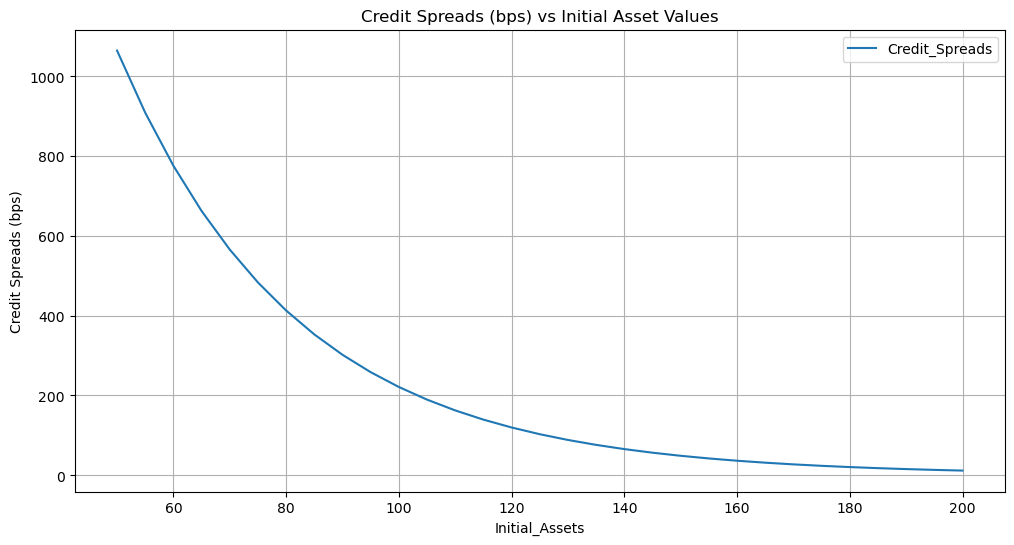

In [59]:
asset_values = [x for x in range(50,205,5)]
credit_spreads = [riskyBondCreditSpread(a,r,sigma_A,T,K) * 1e4 for a in asset_values]
grid_df = pd.DataFrame(data={'Initial_Assets': asset_values, 'Credit_Spreads': credit_spreads})  
grid_df.set_index("Initial_Assets", inplace = True)

plt = grid_df.plot(figsize = (12, 6), title = "Credit Spreads (bps) vs Initial Asset Values", grid=True)
plt.set_ylabel('Credit Spreads (bps)')

In [60]:
equity_vol = equityVolatility(A,r,sigma_A,T,K) * 100

print('Equity Volatility (pct):', round(equity_vol, 2))

Equity Volatility (pct): 46.52


Text(0, 0.5, 'Equity Volatility (pct)')

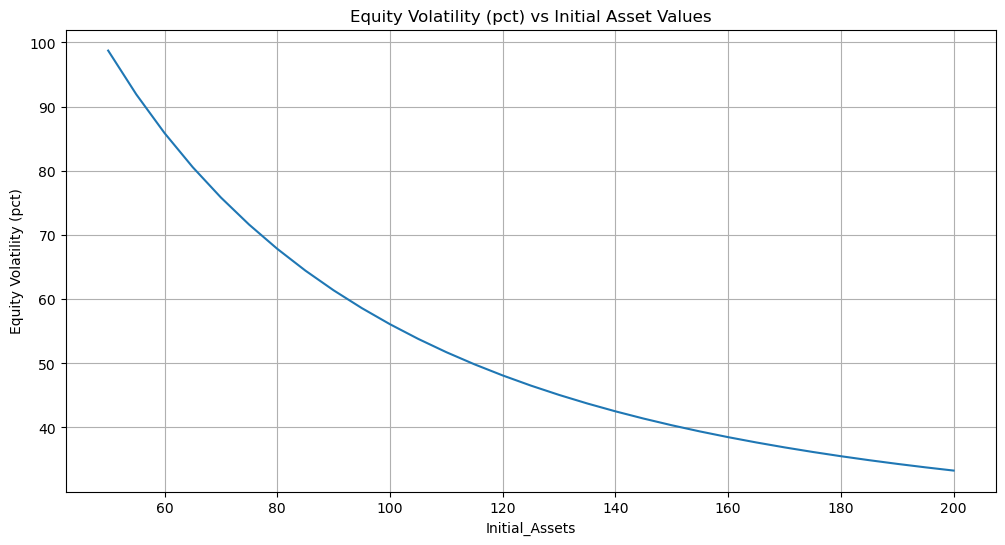

In [61]:
asset_values = [x for x in range(50,205,5)]
equity_volatilities = [equityVolatility(a,r,sigma_A,T,K) * 1e2 for a in asset_values]
exp_recovery_rates = [expectedRecoveryRate(a,r,sigma_A,T,K) * 1e2 for a in asset_values]

grid_df['Equity_Vol'] = equity_volatilities

plt = grid_df['Equity_Vol'].plot(figsize = (12, 6), title = "Equity Volatility (pct) vs Initial Asset Values", grid=True)
plt.set_ylabel('Equity Volatility (pct)')

Text(0, 0.5, 'Expected Recovery Rate (pct)')

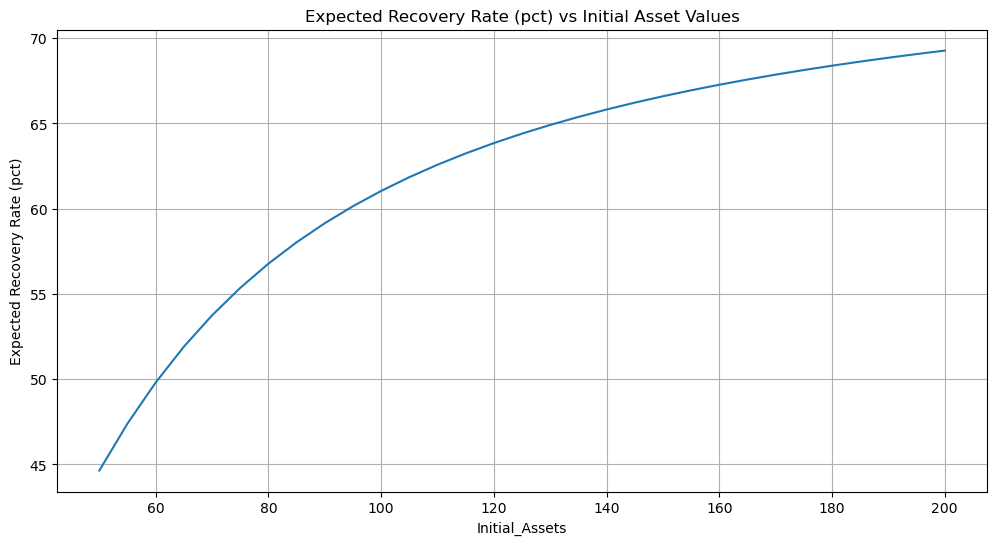

In [62]:
grid_df['Exp_Rec_Rate'] = exp_recovery_rates

plt = grid_df['Exp_Rec_Rate'].plot(figsize = (12, 6), title = "Expected Recovery Rate (pct) vs Initial Asset Values", grid=True)
plt.set_ylabel('Expected Recovery Rate (pct)')

### HW5Q3 - CDS Intrinisc Index analysis on CDX IG 5Y
1. Load and explore the CDX IG 5Y symbology, basket composition and market data. How many CDS contracts are in the CDX index basket? What are the contractual specs and weights of each CDS? Remember that each CDS is identical to the CDX index and the basket has uniform weights.Compute mean, median and standard deviation of CDS Par Spreads in the basket. Sort the basket dataframe by CDS Par Spreads and plot the chart of CDS Par Spreads.
2. Calibrate the US SOFR yield curve (via bootstrapping).
3. Compute the intrinsic Premium Leg PV of the CDX index basket. For each instrument in the basket, create the CDS object. Use the calibrated SOFR discount curve and the CDS Par Spreads to calibrate the individual hazard rate / survival probability curves. Compute the Premium Leg PV for each CDS and aggregate the intrinsic Premium Leg PV of the basket (using basket weights).
4. Compute the intrinsic Default Leg PV of the CDX index basket. Compute the Default Leg PV for each CDS and determine the intrinsic Default Leg PV of the basket (using basket weights).
5. Compute the intrinsic PV and Par Spread of the CDX index basket. Compute the intrinsic index PV. Compute the CDX instrinsic index Par Spread (using ratio of CDX default vs premium legs).

In [80]:
cdx_symbology_df = pd.read_excel(os.path.join(mydir,'data', 'cdx_symbology.xlsx'))
cdx_symbology_df.set_index('symbol', inplace=True)

# Identfy the CDX IG 5Y Series 40 index
cdx_IG_40_5Y_symbology_df = cdx_symbology_df.loc['CDX_CDXIG540']
print(cdx_IG_40_5Y_symbology_df.T)  

ticker                        CDXIG540
class                           Curncy
security                 MARKIT CDX IG
name         MARKIT CDX.NA.IG.40 06/28
type               CREDIT DEFAULT SWAP
dcc                            ACT/360
cpn_first          2023-06-20 00:00:00
maturity           2028-06-20 00:00:00
currency                           USD
Name: CDX_CDXIG540, dtype: object


In [82]:
# cdx_basket_df
cdx_basket_df = pd.read_excel(os.path.join(mydir,'data', 'cdx_ig_40_5y_basket_composition.xlsx'))

print('Number of CDS contracts in the basket:', cdx_basket_df.shape[0])

Number of CDS contracts in the basket: 125


In [83]:
# CDS IG contracts specs are identical to the CDX IG ones, printed above
cds_basket_weight = 1 / cdx_basket_df.shape[0]
print('CDS specs and weights: coupon = 100 bps, maturity = 2028-06-20, dcc = ACT/360, weights (pct) =', cds_basket_weight * 100)


CDS specs and weights: coupon = 100 bps, maturity = 2028-06-20, dcc = ACT/360, weights (pct) = 0.8


In [84]:
# Compute mean, median and standard deviation of CDS Par Spreads in the basket.
print('Mean, median and standard deviation of CDS Par Spreads in the basket:')
print(cdx_basket_df['cds_par_spread_5y'].describe()[['mean', '50%', 'std']])

Mean, median and standard deviation of CDS Par Spreads in the basket:
mean    87.348720
50%     67.880000
std     55.735455
Name: cds_par_spread_5y, dtype: float64


Text(0.5, 0, 'Ticker')

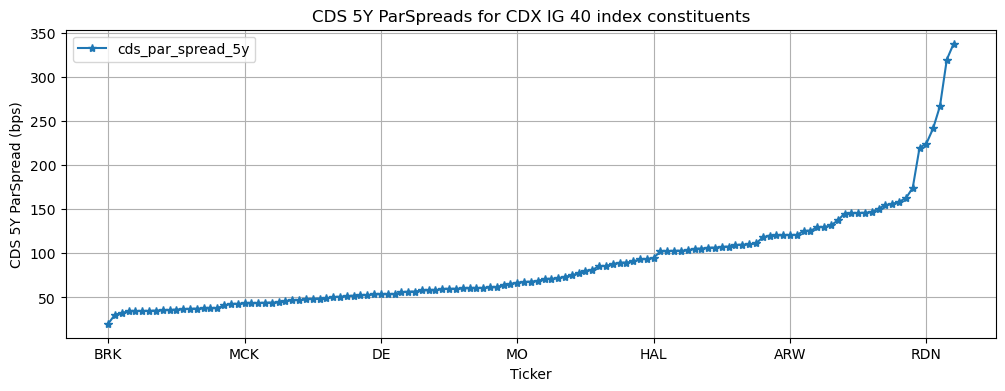

In [85]:
# Sort the basket dataframe by CDS Par Spreads and plot the chart of CDS Par Spreads.
cdx_basket_df.sort_values('cds_par_spread_5y', inplace=True)
plt = cdx_basket_df.plot(x='ticker', y='cds_par_spread_5y', grid=True, style='*-', title='CDS 5Y ParSpreads for CDX IG 40 index constituents', figsize=(12,4))
plt.set_ylabel('CDS 5Y ParSpread (bps)')
plt.set_xlabel('Ticker')

In [87]:
# Load SOFR symbology and market data quotes
sofr_symbology_df = pd.read_excel(os.path.join(mydir,'data', 'sofr_swaps_symbology1.xlsx'))
sofr_market_quotes_df = pd.read_excel(os.path.join(mydir,'data', 'sofr_swaps_market_data_eod1.xlsx'))

# combined_df
sofr_df = sofr_symbology_df.merge(sofr_market_quotes_df[sofr_market_quotes_df['date'] == '2023-05-12'], how='left', on=['figi'])
print(sofr_df.head())

# calibrate SOFR discount curve
sofr_yield_curve = calibrate_sofr_curve_from_frame(calc_date, sofr_df, 'mid_rate')
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)

           figi   ticker   class             bbg                     name  \
0  BBG00KFWPJJ9  USOSFR1  Curncy  USOSFR1 Curncy  USD OIS  ANN VS SOFR 1Y   
1  BBG00KFWPJX3  USOSFR2  Curncy  USOSFR2 Curncy  USD OIS  ANN VS SOFR 2Y   
2  BBG00KFWPK15  USOSFR3  Curncy  USOSFR3 Curncy  USD OIS  ANN VS SOFR 3Y   
3  BBG00KFWPK51  USOSFR5  Curncy  USOSFR5 Curncy  USD OIS  ANN VS SOFR 5Y   
4  BBG00KFWPK79  USOSFR7  Curncy  USOSFR7 Curncy  USD OIS  ANN VS SOFR 7Y   

   term  type      dcc exchange country currency status       date  mid_rate  
0     1  SWAP  ACT/360     NONE      US      USD   ACTV 2023-05-12    4.6945  
1     2  SWAP  ACT/360     NONE      US      USD   ACTV 2023-05-12    3.9097  
2     3  SWAP  ACT/360     NONE      US      USD   ACTV 2023-05-12    3.5265  
3     5  SWAP  ACT/360     NONE      US      USD   ACTV 2023-05-12    3.2426  
4     7  SWAP  ACT/360     NONE      US      USD   ACTV 2023-05-12    3.1750  
